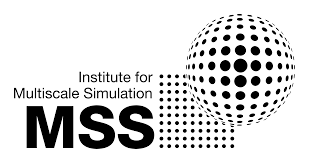


Add SSF logo

# Rotation Algorithms Comparison


----
## Authors:

- Carlos Andrés del Valle:  <cdelv@unal.edu.co>
- Vasileios Angelidakis: <vasileios.angelidakis@fau.de>
- Sudeshna Roy: <sudeshna.roy@fau.de>
- José Daniel Muñoz: <jdmunozc@unal.edu.co>
- Thorsten Poeschel: <thorsten.poeschel@fau.de>
----

## Paper:


## Abstract:

In this Jupyter notebook we .....

----

# Load Packages

In [1]:
using LinearAlgebra
using StaticArrays
using ReferenceFrameRotations
using DifferentialEquations
using Roots 
using Interpolations
using BenchmarkTools
using Statistics
using Plots, StatsPlots
using CSV, DataFrames
using Meshes
using MeshViz
using Printf

# Reference Frame Rotations:

Define some functions for going from the body frame to the lab frame and vice-versa. In other words, global and local frame. Also, some other helper functions. 

In [2]:
function norm2(v::Union{AbstractArray, Quaternion})
    return mapreduce(x -> x*x, +, v)
end
function Lab_to_body(v::SVector{3, Float64}, q::Quaternion{Float64})::SVector{3, Float64}
    return vect(inv(q)*v*q)
end
function Lab_to_body(v::SVector{3, Float64}, R::DCM)::SVector{3, Float64}
    return R*v
end
function Body_to_lab(v::SVector{3, Float64}, q::Quaternion{Float64})::SVector{3, Float64}
    return vect(q*v*inv(q))
end
function Body_to_lab(v::SVector{3, Float64}, R::DCM)::SVector{3, Float64}
    return inv_rotation(R)*v
end
function Body_to_lab(v::SMatrix{3, 3, Float64, 9}, q::Quaternion{Float64})::SMatrix{3, 3, Float64, 9}
    R = quat_to_dcm(q) # Compute the DCM of the quaternion
    return inv_rotation(R)*v*R
end
function Body_to_lab(v::SMatrix{3, 3, Float64, 9}, R::DCM)::SMatrix{3, 3, Float64, 9}
    return inv_rotation(R)*v*R
end;

# Rigid Body Motion:

The motion of rigid bodies is ruled by the Euler equations of motion (equation 1). We will use some analytical solutions for a couple of cases to compare the accuracy of the different algorithms.

## Angular Velocity:

\begin{equation}\label{eq:angular_vel_derivative} \tag{1}
    \begin{split}
        & I_x\dot{\omega_x} = \tau_x + \omega_y\omega_z(I_y - I_z), \\
        & I_y\dot{\omega_y} = \tau_y + \omega_z\omega_x(I_z - I_x), \\
        & I_z\dot{\omega_z} = \tau_z + \omega_x\omega_y(I_x - I_y). \\
    \end{split}
\end{equation}



In [3]:
function ω_dot(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64})
    @inbounds SVector{3, Float64}(
            (M[1] + w[2]*w[3]*(II[2] - II[3]))/II[1],
            (M[2] + w[3]*w[1]*(II[3] - II[1]))/II[2],
            (M[3] + w[1]*w[2]*(II[1] - II[2]))/II[3]
        )
end;

----

## Quaternions:

Most algorithms use quaternions to describe the orientation of the particles. The time derivative of a quaternion is:

\begin{equation}\label{eq:quaternion_derivative} \tag{2}
     \dot{q} = \frac{1}{2} \tilde{\omega} q = \frac{1}{2} q \omega.
\end{equation}

Where $\tilde{\omega}$ is a quaternion with its real part equal to zero, and its vector part is the angular velocity in the lab frame. In the same way, $\omega$ is a quaternion in which the vector part is the angular velocity in the body frame. 

In [4]:
# dquat(q, w)                              # -> Calculate derivative with body frame angular velocity
# 0.5*q*Quaternion(0.0, w[1], w[2], w[3])  # -> Calculate derivative with body frame angular velocity
# 0.5*Quaternion(0.0, w[1], w[2], w[3])*q  # -> Calculate derivative with lab frame angular velocity

An alternative way of representing the rotation is through a DCM (Direct cosine matrix). The time derivative of a DCM is

\begin{equation}
    \dot{R} = \begin{pmatrix}
            0         & \omega_z  & -\omega_y \\
            -\omega_z & 0         & \omega_x \\
            \omega_y  & -\omega_x & 0 \\
            \end{pmatrix}R
\end{equation}

When the angular velocity is in the body frame. When the angular velocity is in the lab frame, it can be calculated as

\begin{equation}
    \dot{R} = \epsilon_{ijk}\omega_jR_{mk}
\end{equation}

Where $\epsilon_{ijk}$ is the Levi Civita symbol. 

In [5]:
# ddcm(R, w)  # -> Calculate derivative with body frame angular velocity

# Calculate derivative with lab frame angular velocity
function R_dot(w::SVector{3, Float64}, R::DCM{Float64})::SMatrix{3, 3, Float64, 9}
    output = MMatrix{3, 3, Float64, 9}(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    for i in 1:3
        @inbounds output[i, :] = cross(w, R[i, :])
    end
    return output
end;

We can verify the output of the previous code with 

In [6]:
#=
using TensorOperations

# Levi Civita
ϵ = zeros(3, 3, 3)
ϵ[1, 2, 3] = ϵ[2, 3, 1] = ϵ[3, 1, 2] = 1
ϵ[1, 3, 2] = ϵ[3, 2, 1] = ϵ[2, 1, 3] = -1

w = [1, 2, 3]
RR = rand(3,3)
res = zeros(3,3)

@tensor begin
    res[m, i] = ϵ[i, j, k] * w[j] * RR[m, k]
end

res - R_dot(SVector{3, Float64}(w), DCM(RR))
=#

----

### Inertia Tensor Values

- We need to satisfy the conditions of the analytic solution. $I_x \neq I_y$ and $I_y = I_z$.

To impose realistic inertia tensor values,  we consider a cylinder with constant density, mass $M$, radius $R$, and height $H$. The [inertia tensor of the cylinder](https://scienceworld.wolfram.com/physics/MomentofInertiaCylinder.html) in its principal axis frame is

\begin{equation}
    J = \begin{pmatrix}
            \frac{1}{2}MR^2 & 0 & 0 \\
            0               & \frac{1}{12}MH^2 + \frac{1}{4}MR^2 & 0 \\
            0               & 0 & \frac{1}{12}MH^2 + \frac{1}{4}MR^2
          \end{pmatrix}
\end{equation}

In this case, the cylinder is aligned with the x direction. 


These values, of course, can be changed to whatever, using a cylinder just to have something that makes sense. 

In [7]:
const ρ = 7750.0     # kg/m^3, steel density
const Rad = 5.0*1e-2   # 5 cm
const Hight = 15.0*1e-2  # 15 cm
const Mass = ρ*π*Rad*Rad*Hight  # M = Vρ

# Inertia tensor components in the principal axis frame
# Remember that Ix != Iy and Iy = Iz
const Ix = 0.5*Mass*Rad*Rad
const Iy = Iz = Mass*Hight*Hight/12 + 0.25*Mass*Rad*Rad

# The initial inertia tensor in the body frame
const InertiaP = SVector{3, Float64}(Ix, Iy, Iz)
const Inertia0 = SMatrix{3, 3, Float64, 9}(
    Ix, 0.0,  0.0, 
    0.0,  Iy, 0.0, 
    0.0,  0.0, Iz
);

println("Ix = ", Ix, " kg m^2")
println("Iy = Iz = ", Iy, " kg m^2")

Ix = 0.011412817061869173 kg m^2
Iy = Iz = 0.022825634123738343 kg m^2



----

## Analytic Solution: 

For the following two solutions, we assume that all the inertia tensor components are non-zero, $I_y = I_z$, and $I_x \neq I_z$. We also require that $\omega_x(t) \neq 0, \; \forall t$.

----

### Assuming $\tau_x \neq 0$:

For this case we require the torque to be $\vec{\tau} = (\tau_x, 0, 0)$ where $\tau_x$ is constant and non-zero. Be careful that the above assumptions are satisfied by the chosen initial conditions and torque. Under these assumptions, the solution of the angular velocity is:

\begin{equation}
    \begin{split}
        & \omega_x(t) = \omega_x(0) + \frac{\tau_x}{I_x}t, \\
        & \omega_y(x) = K_1 \cos{(\eta x)} + K_2 \sin{(\eta x)}, \\
        & \omega_z(x) = \omega_z(x) = E\eta \left( K_2 \cos{(\eta x)} - K_1 \sin{(\eta x)} \right).
    \end{split}
\end{equation}

Where

\begin{equation}
    \begin{split}
        & x = \left(\omega_x(0) + \frac{\tau_x}{I_x}t \right)^2, \\
        & \eta = \frac{I_x}{2\tau_x}\sqrt{\frac{\left|(I_x-I_y)(I_z-I_x)\right|}{I_yI_z}}, \\
        & E = \frac{2I_y\tau_x}{I_x(I_z - I_x)}, \\
        & K_{1} = \frac{E \eta \omega_y(0) \cos\left(\eta \omega_x(0)^{2}\right) - \omega_z(0) \sin\left(\eta \omega_x(0)^{2}\right)}{E \eta },\\
        & K_{2} = \frac{E \eta \omega_y(0) \sin\left(\eta \omega_x(0)^{2}\right) + \omega_z(0) \cos\left(\eta \omega_x(0)^{2}\right)}{E \eta }.
    \end{split}
\end{equation}

-----

### Assuming $\tau_x = 0$:

For this case, we require the torque to be $\vec{\tau} = (0, 0, 0)$. Be careful that the above assumptions are satisfied by the chosen initial conditions and torque. Under these assumptions, the solution of the angular velocity is:

\begin{equation}
    \begin{split}
        & \omega_x(t) = \omega_x(0), \\
        & \omega_y(t) = K_1 \sin{(\eta\omega_x(0)t)} + K_2\cos{(\eta\omega_x(0)t)}, \\
        & \omega_z(t) = B\eta \left(K_1 \cos{(\eta\omega_x(0) t)} - K_2 \sin{(\eta\omega_x(0) t)} \right).
    \end{split}
\end{equation}

Where 

\begin{equation}
    \begin{split}
        & A = \frac{(I_x - I_y)(I_z - I_x)}{I_y\;I_z}, \\
        & \eta = \sqrt{|A|}, \\
        & B = \frac{I_y}{I_z - I_x}, \\
        & K_1 = \frac{\omega_z(0)}{B\eta}, \\
        & K_2 = \omega_y(0).
    \end{split}
\end{equation}


-----

The derivation of these analytical solutions is on our paper. 

-----


In [8]:
const A = (Ix - Iy)*(Iz - Ix)/(Iy*Iz)
const B = Iy/(Iz - Ix)
const sqrt_A = sqrt(-A)

function Sol_ω(t::Float64)::SVector{3, Float64}
    E = 2.0*τx*B/Ix
    ωx = ωx0 + τx*t/Ix
    if τx == 0.0
        η = sqrt_A
        C = B*η
        K1 = ωy0
        K2 = ωz0/C
        D = η*ωx0*t
    else
        η = 0.5*Ix*sqrt_A/τx
        C = E*η
        K1 = (C*ωy0*cos(η*ωx0^2) - ωz0*sin(η*ωx0^2))/C
        K2 = (C*ωy0*sin(η*ωx0^2) + ωz0*cos(η*ωx0^2))/C
        D = η*ωx^2
    end
    
    ωy = K1*cos(D) + K2*sin(D)
    ωz = C*(K2*cos(D) - K1*sin(D))
    return SVector{3, Float64}(ωx, ωy, ωz)
end;

----

# Problem Set Up

Set problem variables. Remember: they are global variables. Be careful!

In [9]:
# Initial orientation of the particle
const q0 = Quaternion(1.0, 0.0, 0.0, 0.0)

# Torque in the principal axis frame x direction, remember that only τx can be non 0. 
τx = 0.0             # N m
const τy = τz = 0.0  # N m

# Initial angular velocity, make sure that ωx0 and τx never make ωx(t) = 0. 
ωx0 =  0.3            # rad/s
ωy0 = -0.9            # rad/s
ωz0 =  0.6            # rad/s

# Torque and initial angular velocity in the principal axis frame
τ  = SVector{3, Float64}(τx, τy, τz)
ω0 = SVector{3, Float64}(ωx0, ωy0, ωz0);

----

# Error calculation:

To calculate errors we just do the relative norm of the absolute error:

\begin{equation}
    \frac{|x - x_{real}|}{|x_{real}|}
\end{equation}

Remember that the norm of a quaternion should be 1, then an error close to 0.1 is already way too big. 

In [10]:
function q_error(q::Quaternion, t)
    return norm(Quaternion(Rkt_sol_q(t)) - q)
end
function q_error(RR::DCM, t)
    return norm(quat_to_dcm(Quaternion(Rkt_sol_q(t))) - RR)
end
function w_error(w_body::SVector, t)
    return norm(Sol_ω(t) - w_body)/norm(Sol_ω(t))
end;

----

# ODE Solver: Benchmark Solution

We use Julia [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) solver to solve equations 1 and 2 to ensure the accuracy of the solution. Equation 2 is solved with the analytical angular velocity. We use these solutions to calculate errors and compare.

In [11]:
# We are in the principal axis frame all the time
function Rkt_ω(du, u, p, t::Float64)
    @inbounds du[1] = (τx + (Iy - Iz)*u[2]*u[3])/Ix
    @inbounds du[2] = (τy + (Iz - Ix)*u[1]*u[3])/Iy
    @inbounds du[3] = (τz + (Ix - Iy)*u[1]*u[2])/Iz
    return nothing
end

# Solve the orientation using the analytic angular velocity
function Rkt_q(du, u, p, t::Float64)
    w = Sol_ω(t)
    @inbounds q = Quaternion(u[1], u[2], u[3], u[4])
    dq = dquat(q, w)
    @inbounds du[1] = dq[1]
    @inbounds du[2] = dq[2]
    @inbounds du[3] = dq[3]
    @inbounds du[4] = dq[4]
    return nothing
end

function Benchmark_Solution(; tmax=10.0)
    tspan = (0.0, tmax)

    # Solve angular velocity
    u0 = [ωx0, ωy0, ωz0]
    prob_w = ODEProblem(Rkt_ω, u0, tspan)
    sol_w = solve(prob_w, alg_hints = [:auto, :interpolant], abstol=1e-14, reltol=1e-12) # We are quite picky with tolerance. We want good accuracy

    # Solve orientation
    u0 = [q0[1], q0[2], q0[3], q0[4]]
    prob_q = ODEProblem(Rkt_q, u0, tspan)
    sol_q = solve(prob_q, alg_hints = [:auto, :interpolant], abstol=1e-14, reltol=1e-12) # We are quite picky with tolerance. We want good accuracy
    return (sol_q, sol_w)
end

tmax = 25.0
Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax);

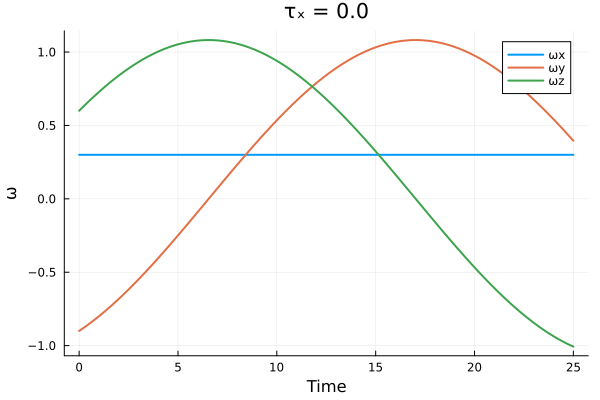

In [12]:
# Plot the solution, just to see it
plot(xlabel="Time", ylabel="ω", title="τₓ = "*string(τx))
plot!( 0.0:0.1:tmax, getindex.(Rkt_sol_w.(0.0:0.1:tmax), [1 2 3])[:,1], label="ωx", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_w.(0.0:0.1:tmax), [1 2 3])[:,2], label="ωy", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_w.(0.0:0.1:tmax), [1 2 3])[:,3], label="ωz", linewidth=2)

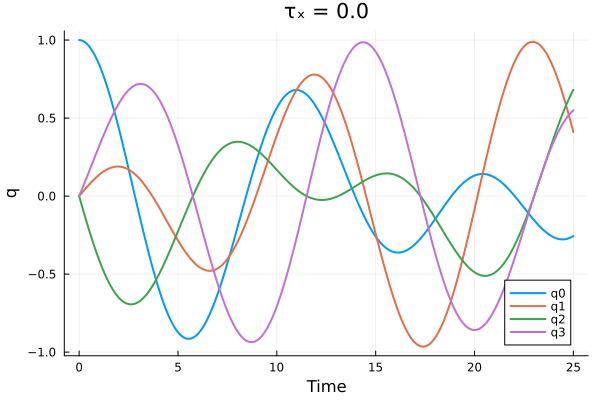

In [13]:
# Plot the solution, just to see it
plot(xlabel="Time", ylabel="q", title="τₓ = "*string(τx))
plot!( 0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,1], label="q0", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,2], label="q1", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,3], label="q2", linewidth=2)
plot!(0.0:0.1:tmax, getindex.(Rkt_sol_q.(0.0:0.1:tmax), [1 2 3 4])[:,4], label="q3", linewidth=2)

In [14]:
function Rkt_Simulation(tmax::Float64, dt::Float64, n_samples::Int64)
    # Arrays to store results
    Error_q = zeros(n_samples)
    Time = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0
    
    for t in range(0.0, tmax, length=n_samples)
        Iter += 1
        @inbounds Time[Iter] = t
        w = Rkt_sol_w(t)
        q = Rkt_sol_q(t)
        @inbounds Prediction[Iter, :] = [q[1],q[2],q[3],q[4],w[1],w[2],w[3]] # We are in the body frame
        
        # Calculate the quaternion error
        # Error_q[Iter] = 0.0 # We use this solution to compare, then the error is always 0
        
        # Calculate the angular velocity error
        solution = Sol_ω(t)
        error = norm2(solution - w) # We are in the body frame
        @inbounds Error_w[Iter] = error
    end
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Runge-Kutta 4:

[Runge-Kutta 4](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods) is by far the most well-known ODE solver. It's also quite good. I like it a lot. However, we will see that is not nearly as good as a professional ODE solver like the one above. Runge-Kutta solves a first-order differential equation with 4 steps (hence the name).

If

\begin{equation}
    \dot{x} = f(x, t),
\end{equation}

then

\begin{equation}
    \begin{split}
        & x(t + dt) = x(t) + \frac{dt}{6}(k_1 + 2k_2 + 2k_3 +k_4), \\
        & k_1 = f\left(x(t), t \right), \\
        & k_2 = f\left(x(t) + dt\frac{k_1}{2}, t + \frac{dt}{2}\right),\\
        & k_3 = f\left(x(t) + dt\frac{k_2}{2}, t + \frac{dt}{2}\right),\\
        & k_4 = f\left(x(t) + dtk_3 , t + dt\right).\\
     \end{split}
\end{equation}

Here we can see why Runge-Kutta is not used for particle based simulation methods like MD and DEM... Evaluating $f$ means calculating forces. In this notebook, we have a given torque, then evaluating $f$ won't have any cost, but in real life, it will be very costly. Also, if you are willing to do 4 force calculations per step there are better methods available. For example, [PEFRL](https://arxiv.org/abs/cond-mat/0110585) (for translational motion). Runge-Kutta is not known for being the most stable method after all... It's also quite slow. 

In [15]:
function Rkt4_f(x::SVector{7, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64})::SVector{7, Float64}
    @inbounds q = Quaternion(x[1], x[2], x[3], x[4])
    @inbounds w = SVector{3, Float64}(x[5], x[6], x[7])
    
    # Compute derivatives
    q_dot = dquat(q, w)  # dquat calculates the quaternion derivative. Is part of ReferenceFrameRotations.jl
    w_dot = ω_dot(w, M, II)
    
    return @inbounds SVector{7, Float64}(q_dot[1], q_dot[2], q_dot[3], q_dot[4], w_dot[1], w_dot[2], w_dot[3])
end

"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Rkt4_step(q::Quaternion, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)
    M = τ # In this case, we already have the torque in the principal frame (and its constant)
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Runge-Kutta 7D vector
    @inbounds X = SVector{7, Float64}(q[1], q[2], q[3], q[4], w[1], w[2], w[3])
    
    k1 = Rkt4_f(X            , M, II) # We would need to update the torque on each call if it werent constant
    k2 = Rkt4_f(X + 0.5*dt*k1, M, II)
    k3 = Rkt4_f(X + 0.5*dt*k2, M, II)
    k4 = Rkt4_f(X + dt*k3    , M, II)
    X += dt*(k1 + 2.0*k2 + 2.0*k3 + k4)/6
    
    @inbounds q = Quaternion(X[1], X[2], X[3], X[4])
    if normalize q /= norm(q); end   # normalize the quaternion
    
    @inbounds w = SVector{3, Float64}(X[5], X[6], X[7])
    
    # Go back to the global reference frame
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Rkt4_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0  # Initial time
    q = q0 # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Rkt4_step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

---

# Direct Euler:

This algorithm is used by:

- Mfix: In their [docs](https://mfix.netl.doe.gov/doc/mfix-archive/mfix_current_documentation/dem_doc_2012-1.pdf) they show that they have 2 algorithms, Direct Euler and 2th order Adams Bashforth. Euler is the default.

- BlazeDEMGPU: In this [paper](https://www.sciencedirect.com/science/article/pii/S235271101630005X) they say near eq 7 that they use Direct Euler. 

- EDEM: [here](https://2022.help.altair.com/2022.2/EDEM/Simulator.htm) says they use Euler and both Position and Velocity Verlet. Also [here](https://altair.com/docs/default-source/resource-library/ebook_what_is_dem_theoretical_background_behind_the_discrete_element_method.pdf?sfvrsn=975cfcf1_3) page 9. Euler is the default. 


Direct Euler is simple. Just make time steps with the first term of the Taylor expansion:

\begin{equation}
    \begin{split}
        & x(t+dt) = x(t) + dt\dot{x}(x, t)
     \end{split}
\end{equation}

Equations 1 and 2 are the derivatives we need for integrating the motion of the rigid body. 

----

<font color='red'>
Warning: In the algorithm derivation, it is implicit that the second derivative should not depend on the first one (the angular velocity derivative depends on angular velocity). But, in many cases, one can get away with it. The same happens in the LeapFrog and Direct Euler algorithms. This is because they come from the Taylor series expansion of f(x, t). 
</font>

In [16]:
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Direct_Euler_step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)
    # Move torque to principal axis frame
    M = τ # In this case, we already have the torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update angular velocity in the principal axis frame
    w +=  ω_dot(w, M, II)*dt
    
    # Update orientation
    q += dquat(q, w)*dt  # dquat calculates the quaternion derivative. Is part of ReferenceFrameRotations.jl
    if normalize q/= norm(q); end   # normalize the quaternion
    
    # Go back to the global reference frame
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Direct_Euler_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0  # Initial time
    q = q0 # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Direct_Euler_step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Velocity Verlet Algorithm:

This algorithm is used by:

- EDEM: [here](https://2022.help.altair.com/2022.2/EDEM/Simulator.htm) says they use Euler and Position and Velocity Verlet. Also [here](https://altair.com/docs/default-source/resource-library/ebook_what_is_dem_theoretical_background_behind_the_discrete_element_method.pdf?sfvrsn=975cfcf1_3) page 9. Euler is the default.  

- LIGGGHTS: In the docs, they say that they use Verlet [here](https://www.cfdem.com/media/DEM/docu/run_style.html).

- GranOO: In the docs, they say that they use Verlet [here](https://www.granoo.org/doc.html#plugin-velocity-verlet-step1). Also in the [paper](https://www.sciencedirect.com/science/article/abs/pii/S0965997814000672?via%3Dihub).

Velocity Verlet goes as follows
\begin{equation}
    \begin{split}
        & \omega\left(t + \frac{dt}{2}\right) = \omega(t) + \frac{dt}{2} M(t) \\
        & q(t + dt) = q(t) + dt \dot{q}\left(\omega\left(t + \frac{dt}{2}\right)\right) \\
        & \text{Compute $M(t + dt)$} \\
        & \omega(t + dt) = \omega\left(t + \frac{dt}{2}\right) + \frac{dt}{2} M(t + dt) \\
    \end{split}
\end{equation}

For this one, we are going to work in the body frame. 

----

<font color='red'>
Warning: In the algorithm derivation, it is implicit that the second derivative should not depend on the first one (the angular velocity derivative depends on angular velocity). But, in many cases, one can get away with it. The same happens in the LeapFrog and Direct Euler algorithms. This is because they come from the Taylor series expansion of f(x, t). 
</font>

In [17]:
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Verlet_step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)
    # Move torque to principal axis frame
    M = τ # In this case, we already have the torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update angular velocity in the principal axis frame
    w +=  ω_dot(w, M, II)*dt*0.5
    
    # Update orientation
    q += dquat(q, w)*dt  # dquat calculates the quaternion derivative. Is part of ReferenceFrameRotations.jl
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Recalculate Forces
    M = τ # In this case, we already have the torque in the principal frame
    
    # Update angular velocity in the principal axis frame
    w +=  ω_dot(w, M, II)*dt*0.5
    
    # Go back to the global reference frame
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Verlet_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0  # Initial time
    q = q0   # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Verlet_step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

---

# Augmented Second Order Buss Algorithm:

This algorithm is used by:

- PFC: The implementation here follows from PFC [docs](https://docs.itascacg.com/pfc600/pfc/docproject/source/manual/numerical_simulations_with_pfc/pfc_formulation/law_of_motion.html?highlight=integration).


The original paper: [Accurate and Efficient Simulation of Rigid-Body Rotations](https://www.sciencedirect.com/science/article/abs/pii/S0021999100966026).


This algorithm is a bit unique in the sense that it rotates the inertia tensor to the lab frame instead of rotating the angular velocities and torques to the body frame. PFC doc state that they only store q, L, and J. Then, the algorithm goes as follows:

\begin{equation}
    \begin{split}
        & I(t) = q(t) J q^{*}(t), \\
        & \vec{\omega}(t) = I^{-1}(t)L(t), \\
        & \dot{\vec{\omega}}(t) = I^{-1}(t)\left(\vec{M}(t) - \vec{\omega}(t) \times \vec{L}(t)\right), \\
        & \bar{\omega} = \vec{\omega}(t) + \frac{dt}{2}\dot{\vec{\omega}}(t) + \frac{dt^2}{12}(\dot{\vec{\omega}}(t)\times \vec{\omega}(t)), \\
        & \theta = |\bar{\omega}|dt, \\
        & q(t + dt) = \left(\cos{\left(\frac{\theta}{2}\right)} + \frac{\bar{\omega}}{|\bar{\omega}|}\sin{\left(\frac{\theta}{2}\right)}\right)q(t), \\
        &  L(t + dt) = L(t) + dtM(t).
    \end{split}
\end{equation}


Where $\vec{\omega}$ is the angular velocity, $\vec{M}$ the torque, $\vec{L}$ the angular momentum, and $q$ the orientation quaternion. $I$ is the inertia tensor in the lab frame and can be calculated using the inertia tensor in the body frame $J$. To rotate a matrix with a quaternion, we first need to convert the quaternion to its corresponding DCM. A DCM is a Direct Cosine Matrix, also known as a rotation matrix. Buss uses DCMs in his paper instead of quaternions. The sines and cosines come from considering the rotation around the axis $\bar{\omega}$ with angle $|\bar{\omega}|dt$. 

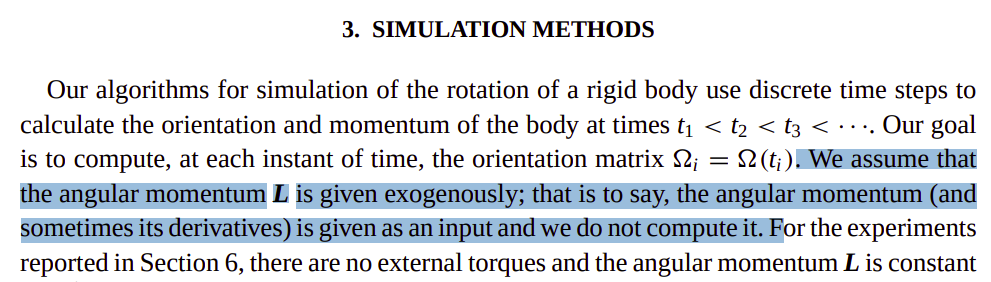

In [18]:
"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- J: Inertia tensor in the principal axis frame. As a 3x3 diagonal matrix. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Buss_Step(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, J::SMatrix{3, 3, Float64, 9}, dt::Float64; normalize::Bool=false)
    # Compute inverse inertia tensor
    Inv_Inertia::SMatrix{3, 3, Float64, 9} = Body_to_lab(inv(J),q)
    
    # Compute current angular velocity w(t) = I^-1(t) L(t)
    w::SVector{3, Float64} = Inv_Inertia*L
    
    # Compute torque
    M = Body_to_lab(τ,q) # In this case we need the torque in the lab frame
    
    # Compute w_dot(t)
    w_dot::SVector{3, Float64} = Inv_Inertia*(M - cross(w,L))
    
    # Omega average
    w_bar::SVector{3, Float64} = w + 0.5*dt*w_dot + (dt/4.0)^2*cross(w_dot, w)
    
    # New orientation, rotation arround axis w_bar of angle θ
    θ::Float64 = norm(w_bar)*dt
    q = cos(θ/2)*q + sin(θ/2)*w_bar*q/norm(w_bar) # q(t + dt)
    if normalize q /= norm(q); end   # normalize the quaternion

    # Compute inverse inertia tensor
    Inv_Inertia = Body_to_lab(inv(J),q)
    
    # Update angular momentum. PFC docs and Buss paper don't say how to do it... I assumed this.
    L += dt*M
    
    # Compute new angular velocity w(t+dt) = I^-1(t+dt) L(t+dt)
    w = Inv_Inertia*L
    
    return (q, Lab_to_body(w,q), L) # We need the body frame velocity
end

function Buss_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0          # Initial time
    q = q0           # Initial Orientation
    L = InertiaP.*Body_to_lab(ω0, q) # Initial Angular momentum
    
    for i in 1:n_steps
        # One step
        q, w_body, L = Buss_Step(q, L, τ, Inertia0, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# 4th Order Johnson Algorithm

This algorithm is used by:

- PFC: PFC [docs](https://docs.itascacg.com/pfc600/pfc/docproject/source/manual/numerical_simulations_with_pfc/pfc_formulation/law_of_motion.html?highlight=integration) for some reason don't clearly state that they use Johnson algorithm. Then, it's easy to think that they use Buss 4th order algorithm. However, in [here](https://docs.itascacg.com/pfc600/pfc/pfcmodule/doc/manual/clump_manual/clump_commands/cmd_clump_order.html#command:clump.order), they directly state that they use Johnson. 


The original paper: [Quaternion-based rigid body rotation integration algorithms for use in particle methods](https://onlinelibrary.wiley.com/doi/abs/10.1002/nme.2210).


The idea of the algorithm is to use a Runge-Kutta-4-like algorithm to update the quaternion orientation. The Runge-Kutta-4 formulation says that if

\begin{equation}
    \dot{x} = f(x, t),
\end{equation}

then

\begin{equation}
    \begin{split}
        & x(t + dt) = x(t) + \frac{dt}{6}(k_1 + 2k_2 + 2k_3 +k_4), \\
        & k_1 = f\left(x(t), t \right), \\
        & k_2 = f\left(x(t) + dt\frac{k_1}{2}, t + \frac{dt}{2}\right),\\
        & k_3 = f\left(x(t) + dt\frac{k_2}{2}, t + \frac{dt}{2}\right),\\
        & k_4 = f\left(x(t) + dtk_3 , t + dt\right).\\
     \end{split}
\end{equation}

In this case
\begin{equation}
     \dot{x} = \dot{q}(\omega)
\end{equation}

This is important. If you want to use equation 2 to calculate $\dot{q}$, you need to move the angular velocity to the body frame. In the PFC docs, this is not clear, and I had a lot of problems trying to understand why the algorithm dint work. 

To finish, we need to update the angular momentum. Johnson suggests using a second-order predictor-corrector algorithm for evolving angular momentum:

\begin{equation}
    \begin{split}
        & \dot{x} = f(x, t) \\
        & S_1 = f(x, t), \\
        & \tilde{x}(t + dt) = x(t) + dt S_1 \\
        & S_2 = f\left(\tilde{x}(t + dt), t + dt\right) \\
        & x(t + dt) = x(t) + \frac{dt}{2}(S_1 + S_2) \\
    \end{split}
\end{equation}

In practice, this would require 2 force calculations and doing the above algorithm for the quaternion update 2 times. Note that this method has the same order as Direct Euler, but it's supposed to provide a better approximation. However, here the torque is constant so we will use the direct Euler version. 


- In the PCF docs, they show an equivalent way of doing it with a less confusing notation than the paper. However, in the paper, they use $L + dt M$ to update the quaternion, and in the PFC docs, they don't add the $dt M$. We will stick to the paper in this case. 

In [19]:
function Johnson_Rkt4_f(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, Inv_J::SMatrix{3, 3, Float64, 9}, dt::Float64)   
    LL::SVector{3, Float64} = L # + M*dt # In Johnson paper they add dt*M, in PFC docs they dont. 
    w::SVector{3, Float64} = Body_to_lab(Inv_J, q)*LL  # Angular velocity in the lab frame, PFC and the paper do it this way....
    
    # Compute derivatives, this way theres no need to move angular velocity to body frame
    return 0.5*Quaternion(0.0, w[1], w[2], w[3])*q  # See PFC docs
end

"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- J: Inertia tensor in the principal axis frame. As a 3x3 diagonal matrix. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Johnson_Step(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, J::SMatrix{3, 3, Float64, 9}, dt::Float64; normalize::Bool=true)
    # Compute inverse inertia tensor in the principal axis frame
    Inv_J::SMatrix{3, 3, Float64, 9} = inv(J)   # J^-1
    
    # Compute torque, in this case we need it in the lab frame
    M = Body_to_lab(τ, q)
    
    # Runge-Kutta-4 like quaternion update
    k1::Quaternion{Float64} = Johnson_Rkt4_f(q            , L, M, Inv_J, dt)
    k2::Quaternion{Float64} = Johnson_Rkt4_f(q + 0.5*dt*k1, L, M, Inv_J, dt)
    k3::Quaternion{Float64} = Johnson_Rkt4_f(q + 0.5*dt*k2, L, M, Inv_J, dt)
    k4::Quaternion{Float64} = Johnson_Rkt4_f(q + dt*k3    , L, M, Inv_J, dt)
    q += dt*(k1 + 2.0*k2 + 2.0*k3 + k4)/6.0
    if normalize q/=norm(q); end
    
    # Compute torque, in this case we need it in the lab frame
    M = Body_to_lab(τ, q)
    
    # Update angular momentum in lab frame
    L += dt*M
    
    # Angular velocity in the body frame 
    w::SVector{3, Float64} = Inv_J*Lab_to_body(L, q)
    
    return (q, w, L) # We need the body frame velocity
end

function Johnson_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0          # Initial time
    q = q0           # Initial Orientation
    L = Inertia0*Body_to_lab(ω0, q) # Initial Angular momentum
    
    for i in 1:n_steps
        # One step
        q, w_body, L = Johnson_Step(q, L, τ, Inertia0, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Fincham Leapfrog:

This algorithm is used by:

- YADE: YADE [docs](https://www.yade-dem.org/doc/formulation.html#orientation-aspherical).
- Esys_Particle: [Paper](https://www.researchgate.net/publication/44003760_The_ESyS_Particle_A_New_3-D_Discrete_Element_Model_with_Single_Particle_Rotation) (page 11).

- WooDEM: wooDem [docs](https://woodem.org/theory/leapfrog.html#orientation) are exaclty the same as YADE docs.


The original paper: [Leapfrog Rotational Algorithms](https://www.tandfonline.com/doi/abs/10.1080/08927029208022474).

This algorithm is a leapfrog-like algorithm that interpolates the quaternion at mid-step to improve the prediction. Also, we use the angular momentum instead of the angular velocity. It goes as follows:

First, we update angular momentum in a Leapfrog fashion 

\begin{equation}
    L\left(t + \frac{dt}{2}\right) = L\left(t - \frac{dt}{2}\right) + dt M(t).
\end{equation}

Then, We update the quaternion with 2 steps evaluating the quaternion derivative at different angular velocities

\begin{equation}
    \begin{split}
        & q_a = q + \frac{dt}{2}\dot{q}\left(\omega(t)\right), \\
        & q(t + dt) = q + dt\dot{q}_a\left(\omega\left(t + \frac{dt}{2}\right)\right).
    \end{split}
\end{equation}

The angular velocities are in the body frame and can be calculated like this:

\begin{equation}
    \begin{split}
        & \omega(t) = A\left(L\left(t - \frac{dt}{2}\right) + \frac{dt}{2}M(t)\right), \\
        & \omega\left(t + \frac{dt}{2}\right) = A L\left(t + \frac{dt}{2}\right).
    \end{split}
\end{equation}

Where A is the rotation matrix from the lab to the body reference frame. So, to evaluate the quaternion derivative (equation 2) we need the move the angular velocity to the body frame. We could do it without changing the frame too.

In [20]:
"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- normalize: Whether or not to normalize the quaternion.
"""
function Fincham_Step(q::Quaternion{Float64}, L::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=true)    
    # Compute torque
    M = Body_to_lab(τ, q) # In this case we need the torque in the lab frame
    
    # Update angular momentum
    L_half::SVector{3, Float64} = L + 0.5*dt*M 
    L += dt*M
    
    # Angular velocity in the body frame
    w_half::SVector{3, Float64} = Lab_to_body(L_half, q)./II
    w::SVector{3, Float64} = Lab_to_body(L, q)./II
    
    # Calculate mid step quaternion
    q_half::Quaternion{Float64} = q + 0.5*dt*dquat(q, w_half)  # q(t + dt/2)
    if normalize q_half /= norm(q_half); end
    
    # Update orientation
    q += dt*dquat(q_half, w)
    if normalize q /= norm(q); end   # normalize the quaternion
    
    return (q, w, L) # We need the body frame velocity
end

function Fincham_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0          # Initial time
    q = q0           # Initial Orientation
    L = InertiaP.*Body_to_lab(ω0, q) # Initial Angular momentum
    
    # Initialize leapfrog
    L -= 0.5*dt*Body_to_lab(τ,q) # L(t - dt/2)
    
    for i in 1:n_steps
        # One step
        q, w_body, L = Fincham_Step(q, L, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# Omelyan Algorithm: 

This algorithm is used by:

- YADE: (In the future)
- MercuryDPM: (In the future)

The original paper: [Algorithm for numerical integration of the rigid-body equations of motion](https://arxiv.org/abs/physics/9901027).

The algorithm assumes we are in the principal axis frame and goes as follows:

\begin{equation}\tag{3}
    \begin{split}
        &\vec{\omega}\left(t+\frac{dt}{2}\right) = \vec{\omega}\left(t-\frac{dt}{2}\right) + dt\dot{\vec{\omega}}(t). \\
        & q(t+dt) = \frac{\left(1-\frac{dt^2}{16}|\vec{\omega}\left(t+\frac{dt}{2}\right)|^2\right) + dtQ(\vec{\omega}\left(t+\frac{dt}{2}\right))}{1 + \frac{dt^2}{16}|\vec{\omega}\left(t+\frac{dt}{2}\right)|^2}q(t).
    \end{split}
\end{equation}

$\dot{\vec{\omega}}$ is calculated with equation 1. $Q$ from equation 2. However, note that equation 1 requires the angular velocity at time $t$, which is unknown. To solve this, we approximate

\begin{equation}
    \omega_\alpha(t)\omega_\beta(t) \approx \frac{1}{2}\left(\omega_\alpha\left(t-\frac{dt}{2}\right)\omega_\beta\left(t-\frac{dt}{2}\right) + \omega_\alpha\left(t+\frac{dt}{2}\right)\omega_\beta\left(t+\frac{dt}{2}\right)\right).
\end{equation}

This approximation converts equation 3 into a system of nonlinear equations which can be efficiently solved by iteration. The initial guess is $\vec{\omega}\left(t-\frac{dt}{2}\right)$. For a sufficiently small time step, three iterations are enough to achieve convergence. 

In [21]:
function Omelyan_98_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3)::SVector{3, Float64}
    ww::SVector{3, Float64} = w
    # Solve non-linear system
    for i in 1:niter
        @inbounds ww = w + dt*SVector{3, Float64}(
            (M[1] + 0.5*(w[2]*w[3]+ww[2]*ww[3])*(II[2]-II[3]))/II[1],
            (M[2] + 0.5*(w[3]*w[1]+ww[3]*ww[1])*(II[3]-II[1]))/II[2],
            (M[3] + 0.5*(w[1]*w[2]+ww[1]*ww[2])*(II[1]-II[2]))/II[3])
    end
    return ww
end
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function Omelyan_Step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3, normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update velocity 
    w = Omelyan_98_move_w(w, M, II, dt, niter=niter) # w(d + dt/2)
    
    # Update quaternion
    a::Float64 = norm2(w)*(dt/4.0)^2
    a1::Float64 = 1.0 - a
    a2::Float64 = 1.0 + a
    q = (a1*q + dquat(q, w)*dt)/a2
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Omelyan_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w -= 0.5*dt*ω_dot(Lab_to_body(w, q), τ, InertiaP) # w(t - dt/2)

    for i in 1:n_steps
        # One step
        q, w_body, w = Omelyan_Step(q, w, τ, InertiaP, dt, niter=niter, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# MercuryDPM algorithm

The algorithm used by MercuryDPM for non-spherical particles comes from the PFC4 manual and uses DCMs to represent the particle orientation. We are not aware of the algorithm's name or origin. The current version of PFC uses Buss or Johnson algorithms. The algorithm goes as follows:

First, we update the angular velocity and momentum by iteration:
\begin{equation}
    \begin{split}
        & \vec{L_{n}} = I\vec{\omega_n}\quad,\\
        & \vec{\omega_{n+1}} = \vec{\omega_0} + dtI^{-1}\left(\vec{M} - \vec{\omega_{n}}\times \vec{L_{n}}\right)\quad.
    \end{split}
\end{equation}
In this algorithm, all the quantities are on the lab reference frame. Then, the orientation is updated as
\begin{equation}
    A(t + dt) = A(t) + dt\dot{A}(t)\quad.
\end{equation}

Where $A$ is the DCM or rotation matrix representing the particle orientation. The derivative of the rotation matrix is
\begin{equation}
    \dot{A} = \epsilon_{ijk}\omega_j A_{mk}\quad,
\end{equation}
where $\epsilon_{ijk}$ is the Levi-Civita symbol. We are using Einsteins summation notation. 

In [22]:
function Mercury_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, I::SMatrix{3, 3, Float64, 9}, Inv_I::SMatrix{3, 3, Float64, 9}, dt::Float64; niter::Int64=3)::SVector{3, Float64}
    w_n::SVector{3, Float64} = w
    
    # Update angular velocity in the principal axis frame
    for i in 1:niter
        L_n::SVector{3, Float64} = I*w_n
        w_n = w + dt*Inv_I*(M - cross(w_n, L_n)) # w0 + dt*w_dot
    end
    return w_n
end

"""
- q: Current particle orientation.
- L: Current angular momentum (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- J: Inertia tensor in the principal axis frame. As a 3x3 diagonal matrix. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function Mercury_step(RR::DCM{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, J::SMatrix{3, 3, Float64, 9}, dt::Float64; niter::Int64=3, normalize::Bool=true)    
    # Calculate Lab frame Inertia tensor
    I::SMatrix{3, 3, Float64, 9} = Body_to_lab(J, RR)
    Inv_I::SMatrix{3, 3, Float64, 9} = inv(I)
    
    # Move torque to lab frame
    M = Body_to_lab(τ, RR)
    
    # Update angular velocity
    w = Mercury_move_w(w, M, I, Inv_I, dt, niter=niter) # w(t + dt/2)
    
    # Update orientation
    RR += dt*R_dot(w, RR)
    if normalize RR = orthonormalize(RR); end
    
    return (RR, Lab_to_body(w, RR), w) # We need the body frame velocity
end

function Mercury_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=true)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0  # Initial time
    q = q0 # Initial Orientation
    RR = quat_to_dcm(q)
    
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w -= 0.5*dt*ω_dot(Lab_to_body(w, q), τ, InertiaP) # w(t - dt/2)
    
    for i in 1:n_steps
        # One step
        RR, w_body, w = Mercury_step(RR, w, τ, Inertia0, dt, niter=niter, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(RR, T)*4.0/9.0 # DCM has 9 numbers, quaternion 4
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# del Valle et al. Algorithm


I developed an improvement over the Omelyan algorithm. The idea is to calculate the quaternion with

\begin{equation}
    \begin{split}
        & q(t+dt) = q(t)\left(\cos{\theta_1} + \frac{\vec{\omega}\left(t + \frac{dt}{2}\right)}{\left|\vec{\omega}\left(t + \frac{dt}{2}\right)\right|}\sin{\theta_1} \right)exp(O(dt^3)) \\
        & q(t+dt) = q(t)\left(\cos{\theta_2} + \frac{\vec{\omega}\left(t\right)}{\left|\vec{\omega}\left(t\right)\right|}\sin{\theta_2} \right)\left(\cos{\theta_3} + \frac{\vec{\dot{\omega}}\left(t\right)}{\left|\vec{\dot{\omega}}\left(t\right)\right|}\sin{\theta_3} \right)exp(O(dt^3)) \\
        & \theta_1 = \frac{dt}{2}\left|\vec{\omega}\left(t + \frac{dt}{2}\right)\right|, \qquad \theta_2 = \frac{dt}{2}\left|\vec{\omega}\left(t\right)\right|, \qquad \theta_3 = \frac{dt^2}{4}\left|\vec{\dot{\omega}}\left(t\right)\right| \\
    \end{split}
\end{equation}

depending on if we are using leapfrog or not. For the angular velocity we can choose whatever, but I suggest using SSPRK3 like algorithm (inspired by Johnson):

\begin{equation}
    \begin{split}
        & \vec{K_1} = dt\vec{\dot{\omega}}(\vec{\omega}, \vec{M}(t))\\
        & \vec{K_2} = dt\vec{\dot{\omega}}(\vec{\omega} +\vec{ K_1}, \vec{M}(t))\\
        & \vec{K_3} = dt\vec{\dot{\omega}}(\vec{\omega} + \frac{1}{4}(\vec{K_1} + \vec{K_2}), \vec{M}(t))\\
        & \vec{\omega}(t + dt) = \vec{\omega}(t) + \frac{1}{6}(\vec{K_1} + \vec{K_2} + 4\vec{K_3})
    \end{split}
\end{equation}

----

# del Valle et al. LeapFrog Algorithm:

In [23]:
function Carlos_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64)::SVector{3, Float64}
    # SSPRK3
    k1::SVector{3, Float64} = dt*ω_dot(w                 , M, II)
    k2::SVector{3, Float64} = dt*ω_dot(w + k1            , M, II)
    k3::SVector{3, Float64} = dt*ω_dot(w + 0.25*(k1 + k2), M, II)
    return w + (k1 + k2 + 4.0*k3)/6.0
end

"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function Carlos_LeapFrog_Step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update velocity w(t + dt/2)
    w = Carlos_move_w(w, M, II, dt)
    
    # Update quaternion 
    Nw::Float64 = norm(w)
    θ1::Float64 = Nw*dt/2.0   
    if Nw == 0.0  Nw = 1.0; end
    q = q*Quaternion(cos(θ1), sin(θ1)*w/Nw) # q(t + dt)
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity #Body_to_lab(w, q)
end

function Carlos_LeapFrog_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w = Carlos_move_w(Lab_to_body(w, q), τ, InertiaP, -0.5*dt)
    
    for i in 1:n_steps
        # One step
        q, w_body, w = Carlos_LeapFrog_Step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

----

# del Valle et al. Non-Leapfrog Algorithm:

In [24]:
"""
- q: Current particle orientation.
- w: Current angular velocity (in the lab frame) of the particle
- M: Torque (in the lab frame) acting on the particle.
- II: Inertia tensor in the principal axis frame. In this frame, the tensor is diagonal. Then, we assume it's a 3D vector. 
- dt: Time step.
- niter: Number of iterations for solving the nonlinear system. 
- normalize: Whether or not to normalize the quaternion.
"""
function Carlos_Step(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    # Update quaternion 
    Nw::Float64 = norm(w)
    θ1::Float64 = Nw*dt/2.0
    if Nw == 0.0  Nw = 1.0; end
    
    w_dot::SVector{3, Float64} = ω_dot(w,M,II)
    Nw_dot::Float64 = norm(w_dot)
    θ2 = dt*dt*Nw_dot/4.0
    if Nw_dot == 0.0  Nw_dot = 1.0; end
    
    q = q*Quaternion(cos(θ1), sin(θ1)*w/Nw)*Quaternion(cos(θ2), sin(θ2)*w_dot/Nw_dot) # q(t + dt)
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Update velocity w(t + dt)
    w = Carlos_move_w(w, M, II, dt)
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity
end

function Carlos_Simulation(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})

    for i in 1:n_steps
        # One step
        q, w_body, w = Carlos_Step(q, w, τ, InertiaP, dt, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T)
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

# del Valle et al. + Omelyan Angular Velocity

In [25]:
function PEFRL_move_w(w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3)::SVector{3, Float64}
    λ::Float64 = -0.2123418310626054
    w += 0.5*(1.0 - 2.0*λ)*dt*ω_dot(w, M, II)
    w += λ*dt*ω_dot(w, M, II)
    w += λ*dt*ω_dot(w, M, II)
    return w + 0.5*(1.0 - 2.0*λ)*dt*ω_dot(w, M, II)
end

function Carlos_LeapFrog_Step2(q::Quaternion{Float64}, w::SVector{3, Float64}, M::SVector{3, Float64}, II::SVector{3, Float64}, dt::Float64; niter::Int64=3, normalize::Bool=false)
    # Move torque to principal axis frame
    M = τ # In this case, we already have a torque in the principal frame
    
    # Move angular velocity to principal axis frame
    w = Lab_to_body(w, q)
    
    w = Omelyan_98_move_w(w, M, II, dt, niter=niter) # w(d + dt/2)
    
    # Update quaternion 
    Nw::Float64 = norm(w)
    θ1::Float64 = Nw*dt/2.0    
    if Nw == 0.0  Nw = 1.0; end
    q = q*Quaternion(cos(θ1), sin(θ1)*w/Nw) # q(t + dt)
    if normalize q /= norm(q); end   # normalize the quaternion
    
    # Go back to lab frame    
    return (q, w, Body_to_lab(w, q)) # We need the body frame velocity #Body_to_lab(w, q)
end

function Carlos_LeapFrog_Simulation2(tmax::Float64, dt::Float64, n_samples::Int64; niter::Int64=3, normalize::Bool=false)
    # Simulation time parameters
    n_steps = trunc(Int, tmax/dt)
    vis_steps = trunc(Int, n_steps/n_samples)
    
    # Arrays to store results
    Time = Vector{Float64}(undef,n_samples)
    Error_q = Vector{Float64}(undef,n_samples)
    Error_w = Vector{Float64}(undef,n_samples)
    Prediction = Matrix{Float64}(undef,n_samples,7)
    Iter::Int64 = 0

    T = 0.0 # Initial time
    q = q0  # Initial Orientation
    w = Body_to_lab(ω0, q) # Initial Angular velocity
    w_body = zeros(SVector{3})
    
    # Initialize leapfrog
    w = Omelyan_98_move_w(Lab_to_body(w, q), τ, InertiaP, -0.5*dt)
    
    for i in 1:n_steps
        # One step
        q, w_body, w = Carlos_LeapFrog_Step2(q, w, τ, InertiaP, dt, niter=niter, normalize=normalize)
        
        # Update time
        T += dt
        
        # Save data
        if i%vis_steps == 0
            Iter += 1
            @inbounds Time[Iter] = T
            @inbounds Prediction[Iter,:] = [q[1],q[2],q[3],q[4],w_body[1],w_body[2],w_body[3]] # We need the body frame velocity
            
            # Calculate the quaternion error
            @inbounds Error_q[Iter] = q_error(q, T)
            
            # Calculate the angular velocity error
            @inbounds Error_w[Iter] = w_error(w_body, T - 0.5*dt) # Leapfrog velocity is ofset by dt/2
        end
    end
    
    return (Time, Error_q, Error_w, Prediction)
end;

---

# Calculate all errors

Modifying the variables defined at the begining we can explore the effect of the different parameters. Also, we can see that some algorithms do better without torque than others. 

In [26]:
function print_parameters()
    println("Ix = ", Ix)
    println("Iy = ", Iy)
    println("Iz = ", Iz)
    println("q0 = ", q0)
    println("ω0 = ", ω0)
    println("τ = ", τ)
    println("tmax = ", tmax)
    println("dt = ", dt)
end
    
    
# Torque in the principal axis frame x direction, remember that only τx can be non 0. 
τx = Rad*10.0           # N m

# Initial angular velocity, make sure that ωx0 and τx never make ωx(t) = 0. 
ωx0 =  0.3            # rad/s
ωy0 = -0.9            # rad/s
ωz0 =  0.6            # rad/s

# Torque and initial angular velocity in the principal axis frame
τ  = SVector{3, Float64}(τx, τy, τz)
ω0 = SVector{3, Float64}(ωx0, ωy0, ωz0);

In [27]:
# Time parameters
tmax = 1.0      # s

# Time parameters
dt = 1e-5        # s
samples = 100

Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax);
Rkt_Time, Rkt_Error_q, Rkt_Error_w, Rkt_Prediction = Rkt_Simulation(tmax, dt, samples)
Carlos_L_Time, Carlos_L_Error_q, Carlos_L_Error_w, Carlos_L_Prediction = Carlos_LeapFrog_Simulation(tmax, dt, samples, normalize=true)
Euler_Time, Euler_Error_q, Euler_Error_w, Euler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=true)

df = DataFrame(
    Rkt_Time = Rkt_Time,
    Rkt_q1 = Rkt_Prediction[:,1],
    Rkt_q2 = Rkt_Prediction[:,2],
    Rkt_q3 = Rkt_Prediction[:,3],
    Rkt_q4 = Rkt_Prediction[:,4],
    Rkt_w1 = Rkt_Prediction[:,5],
    Rkt_w2 = Rkt_Prediction[:,6],
    Rkt_w3 = Rkt_Prediction[:,7],
    Euler_Time = Euler_Time,
    Euler_q1 = Euler_Prediction[:,1],
    Euler_q2 = Euler_Prediction[:,2],
    Euler_q3 = Euler_Prediction[:,3],
    Euler_q4 = Euler_Prediction[:,4],
    Euler_w1 = Euler_Prediction[:,5],
    Euler_w2 = Euler_Prediction[:,6],
    Euler_w3 = Euler_Prediction[:,7],
    Carlos_L_Time = Carlos_L_Time,
    Carlos_q1 = Carlos_L_Prediction[:,1],
    Carlos_q2 = Carlos_L_Prediction[:,2],
    Carlos_q3 = Carlos_L_Prediction[:,3],
    Carlos_q4 = Carlos_L_Prediction[:,4],
    Carlos_w1 = Carlos_L_Prediction[:,5],
    Carlos_w2 = Carlos_L_Prediction[:,6],
    Carlos_w3 = Carlos_L_Prediction[:,7]
)

# Save the DataFrame to a CSV file
CSV.write("Data/analytical_sol.csv", df)

"Data/analytical_sol.csv"

In [28]:
# Time parameters
tmax = 20.0      # s

# Time parameters
dt = 1e-5        # s
samples = 50

Norm = true # Normalazing the quaternion

# Recalculate benchmark solution if parameters are changed
Rkt_sol_q, Rkt_sol_w = Benchmark_Solution(tmax=tmax); # tmax needs to be bigger than comparison time

# Calculate errors
Rkt_Time, Rkt_Error_q, Rkt_Error_w, Rkt_Prediction = Rkt_Simulation(tmax, dt, samples)
Rkt4_Time, Rkt4_Error_q, Rkt4_Error_w, Rkt4_Prediction = Rkt4_Simulation(tmax, dt, samples, normalize=Norm)
Euler_Time, Euler_Error_q, Euler_Error_w, Euler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=Norm)
Verlet_Time, Verlet_Error_q, Verlet_Error_w, Verlet_Prediction = Verlet_Simulation(tmax, dt, samples, normalize=Norm)
Buss_Time, Buss_Error_q, Buss_Error_w, Buss_Prediction = Buss_Simulation(tmax, dt, samples, normalize=Norm)
Johnson_Time, Johnson_Error_q, Johnson_Error_w, Johnson_Prediction = Johnson_Simulation(tmax, dt, samples, normalize=Norm)
Fincham_Time, Fincham_Error_q, Fincham_Error_w, Fincham_Prediction = Fincham_Simulation(tmax, dt, samples, normalize=Norm)
Omelyan_Time, Omelyan_Error_q, Omelyan_Error_w, Omelyan_Prediction = Omelyan_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
Mercury_Time, Mercury_Error_q, Mercury_Error_w, Mercury_Prediction = Mercury_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
Carlos_L_Time, Carlos_L_Error_q, Carlos_L_Error_w, Carlos_L_Prediction = Carlos_LeapFrog_Simulation(tmax, dt, samples, normalize=Norm)
Carlos_Time, Carlos_Error_q, Carlos_Error_w, Carlos_Prediction = Carlos_Simulation(tmax, dt, samples, normalize=Norm);
Carlos_L_Time2, Carlos_L_Error_q2, Carlos_L_Error_w2, Carlos_L_Prediction2 = Carlos_LeapFrog_Simulation2(tmax, dt, samples, niter=3, normalize=Norm)

Norm = false # Not normalazing the quaternion

# Calculate errors
NRkt4_Time, NRkt4_Error_q, NRkt4_Error_w, NRkt4_Prediction = Rkt4_Simulation(tmax, dt, samples, normalize=Norm)
NEuler_Time, NEuler_Error_q, NEuler_Error_w, NEuler_Prediction = Direct_Euler_Simulation(tmax, dt, samples, normalize=Norm)
NVerlet_Time, NVerlet_Error_q, NVerlet_Error_w, NVerlet_Prediction = Verlet_Simulation(tmax, dt, samples, normalize=Norm)
NBuss_Time, NBuss_Error_q, NBuss_Error_w, NBuss_Prediction = Buss_Simulation(tmax, dt, samples, normalize=Norm)
NJohnson_Time, NJohnson_Error_q, NJohnson_Error_w, NJohnson_Prediction = Johnson_Simulation(tmax, dt, samples, normalize=Norm)
NFincham_Time, NFincham_Error_q, NFincham_Error_w, NFincham_Prediction = Fincham_Simulation(tmax, dt, samples, normalize=Norm)
NOmelyan_Time, NOmelyan_Error_q, NOmelyan_Error_w, NOmelyan_Prediction = Omelyan_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
NMercury_Time, NMercury_Error_q, NMercury_Error_w, NMercury_Prediction = Mercury_Simulation(tmax, dt, samples, niter=3, normalize=Norm);
NCarlos_L_Time, NCarlos_L_Error_q, NCarlos_L_Error_w, NCarlos_L_Prediction = Carlos_LeapFrog_Simulation(tmax, dt, samples, normalize=Norm)
NCarlos_Time, NCarlos_Error_q, NCarlos_Error_w, NCarlos_Prediction = Carlos_Simulation(tmax, dt, samples, normalize=Norm);
NCarlos_L_Time2, NCarlos_L_Error_q2, NCarlos_L_Error_w2, NCarlos_L_Prediction2 = Carlos_LeapFrog_Simulation2(tmax, dt, samples, niter=3, normalize=Norm)

print_parameters()

Ix = 0.011412817061869173
Iy = 0.022825634123738343
Iz = 0.022825634123738343
q0 = Quaternion{Float64}: + 1.0 + 0.0⋅i + 0.0⋅j + 0.0⋅k
ω0 = [0.3, -0.9, 0.6]
τ = [0.5, 0.0, 0.0]
tmax = 20.0
dt = 1.0e-5


# Order Analysis

In [29]:
function Order_Analysis(;tmax=0.6, min_dt=-7, max_dt=-1, samples=20)
    dts = 10 .^ range(min_dt, max_dt, length=samples)
    Errors = zeros(length(dts), 22)
    
    for i in 1:length(dts)
        _, Rkt4_Error_q, Rkt4_Error_w, _ = Rkt4_Simulation(tmax, dts[i], 1)
        _, Euler_Error_q, Euler_Error_w, _ = Direct_Euler_Simulation(tmax, dts[i], 1)
        _, Verlet_Error_q, Verlet_Error_w, _ = Verlet_Simulation(tmax, dts[i], 1)
        _, Buss_Error_q, Buss_Error_w, _ = Buss_Simulation(tmax, dts[i], 1)
        _, Johnson_Error_q, Johnson_Error_w, _ = Johnson_Simulation(tmax, dts[i], 1)
        _, Fincham_Error_q, Fincham_Error_w, _ = Fincham_Simulation(tmax, dts[i], 1)
        _, Omelyan_Error_q, Omelyan_Error_w, _ = Omelyan_Simulation(tmax, dts[i], 1)
        _, Mercury_Error_q, Mercury_Error_w, _ = Mercury_Simulation(tmax, dts[i], 1)
        _, Carlos_L_Error_q, Carlos_L_Error_w, _ = Carlos_LeapFrog_Simulation(tmax, dts[i], 1)
        _, Carlos_Error_q, Carlos_Error_w, _ = Carlos_Simulation(tmax, dts[i], 1)
        _, Carlos_L_Error_q2, Carlos_L_Error_w2, _ = Carlos_LeapFrog_Simulation2(tmax, dts[i], 1)

        Errors[i,1] = Rkt4_Error_q[1]
        Errors[i,2] = Euler_Error_q[1]
        Errors[i,3] = Verlet_Error_q[1]
        Errors[i,4] = Buss_Error_q[1]
        Errors[i,5] = Johnson_Error_q[1]
        Errors[i,6] = Fincham_Error_q[1]
        Errors[i,7] = Omelyan_Error_q[1]
        Errors[i,8] = Mercury_Error_q[1]
        Errors[i,9] = Carlos_L_Error_q[1]
        Errors[i,10] = Carlos_Error_q[1]
        Errors[i,11] = Carlos_L_Error_q2[1]
        Errors[i,12] = Rkt4_Error_w[1]
        Errors[i,13] = Euler_Error_w[1]
        Errors[i,14] = Verlet_Error_w[1]
        Errors[i,15] = Buss_Error_w[1]
        Errors[i,16] = Johnson_Error_w[1]
        Errors[i,17] = Fincham_Error_w[1]
        Errors[i,18] = Omelyan_Error_w[1]
        Errors[i,19] = Mercury_Error_w[1]
        Errors[i,20] = Carlos_L_Error_w[1]
        Errors[i,21] = Carlos_Error_w[1]
        Errors[i,22] = Carlos_L_Error_w2[1]
    end
    return dts, Errors
end;

In [30]:
dts1, Errors1 = Order_Analysis(tmax=1.0);

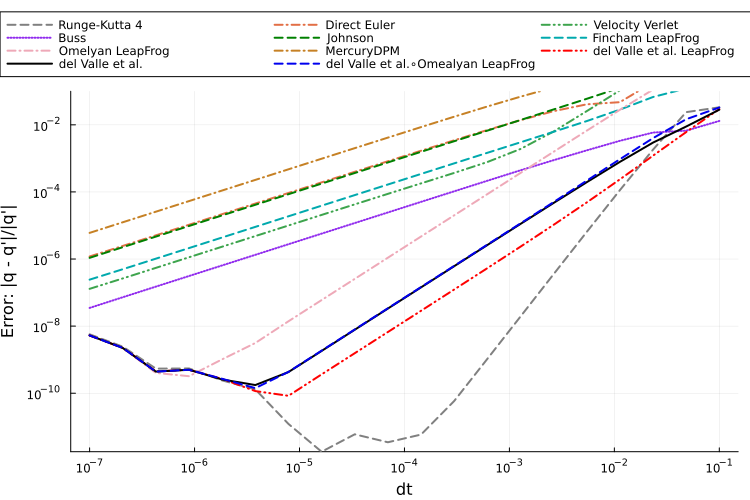

In [31]:
fig = plot(ylabel="Error: |q - q'|/|q'|", xlabel="dt", xscale=:log10, yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(dts1, Errors1[:,1], label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(dts1, Errors1[:,2], label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,3], label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,4], label="Buss", linewidth=2, color=:purple2, linestyle=:auto)
plot!(dts1, Errors1[:,5], label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(dts1, Errors1[:,6], label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,7], label="Omelyan LeapFrog", linewidth=2, color=:pink2, linestyle=:auto)
plot!(dts1, Errors1[:,8], label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(dts1, Errors1[:,9], label="del Valle et al. LeapFrog", linewidth=2, color=:red, linestyle=:dashdotdot)
plot!(dts1, Errors1[:,10], label="del Valle et al.", linewidth=2, color=:black, linestyle=:auto)
plot!(dts1, Errors1[:,11], label="del Valle et al.∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:auto)
xticks!(10 .^ range(-8, 0, length=9))
yticks!(10 .^ range(-26, 4, length=16))
ylims!(-Inf,0.1)

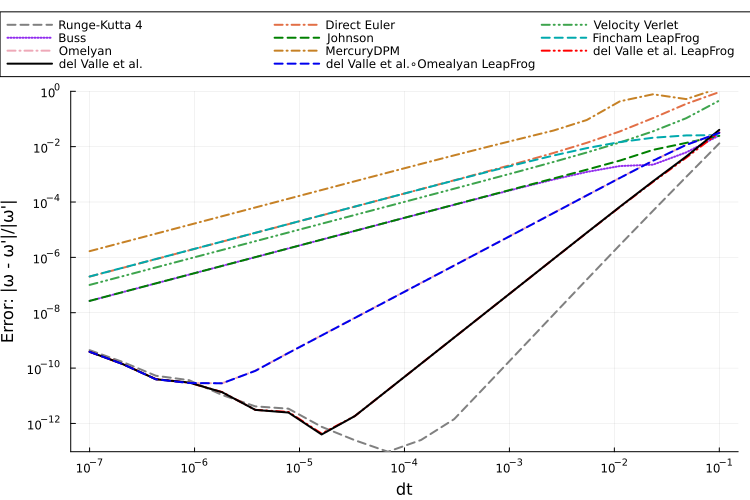

In [32]:
fig = plot(ylabel="Error: |ω - ω'|/|ω'|", xlabel="dt", xscale=:log10, yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(dts1, Errors1[:,12], label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(dts1, Errors1[:,13], label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,14], label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,15], label="Buss", linewidth=2, color=:purple2, linestyle=:auto)
plot!(dts1, Errors1[:,16], label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(dts1, Errors1[:,17], label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(dts1, Errors1[:,18], label="Omelyan", linewidth=2, color=:pink2, linestyle=:auto)
plot!(dts1, Errors1[:,19], label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(dts1, Errors1[:,20], label="del Valle et al. LeapFrog", linewidth=2, color=:red, linestyle=:dashdotdot)
plot!(dts1, Errors1[:,21], label="del Valle et al.", linewidth=2, color=:black, linestyle=:auto)
plot!(dts1, Errors1[:,22], label="del Valle et al.∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:auto)
xticks!(10 .^ range(-8, 0, length=9))
yticks!(10 .^ range(-26, 4, length=16))
ylims!(-Inf,1)

In [33]:
header = ["dt", "RKq", "Eulerq", "Verletq", "Bussq", "Johnsonq", "Finchamq", "Omelyanq", 
    "MercuryDPMq", "CarlosLq", "Carlosq", "CarlosOq", "RKw", "Eulerw", "Verletw", "Bussw", "Johnsonw", 
    "Finchamw", "Omelyanw", "MercuryDPMw", "CarlosLw", "Carlosw", "CarlosOw"]
CSV.write("Data/Latex_dt_error", DataFrame(hcat(dts1, Errors1), header))

"Data/Latex_dt_error"

----

# Plot Erros

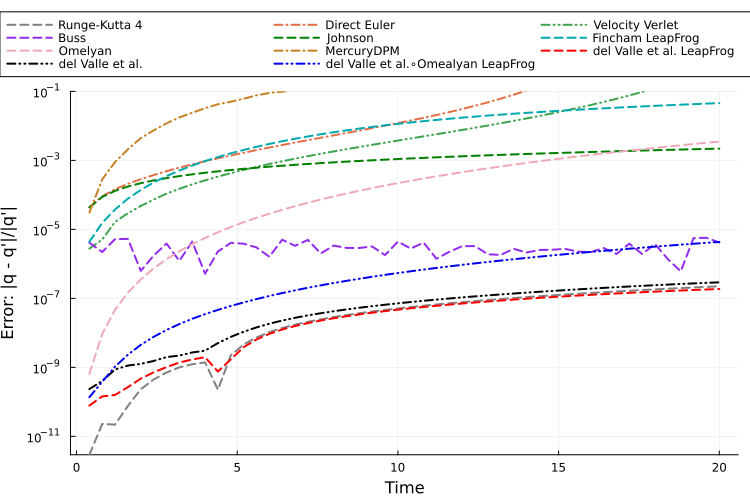

In [34]:
fig = plot(ylabel="Error: |q - q'|/|q'|", xlabel="Time", yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(Rkt4_Time, Rkt4_Error_q, label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(Euler_Time, Euler_Error_q, label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(Verlet_Time, Verlet_Error_q, label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(Buss_Time, Buss_Error_q, label="Buss", linewidth=2, color=:purple2, linestyle=:dash)
plot!(Johnson_Time, Johnson_Error_q, label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(Fincham_Time, Fincham_Error_q, label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(Omelyan_Time, Omelyan_Error_q, label="Omelyan", linewidth=2, color=:pink2, linestyle=:dash)
plot!(Mercury_Time, Mercury_Error_q, label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(Carlos_L_Time, Carlos_L_Error_q, label="del Valle et al. LeapFrog", linewidth=2, color=:red, linestyle=:dash)
plot!(Carlos_Time, Carlos_Error_q, label="del Valle et al.", linewidth=2, color=:black, linestyle=:dashdotdot)
plot!(Carlos_L_Time2, Carlos_L_Error_q2, label="del Valle et al.∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:dashdotdot)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,0.1)

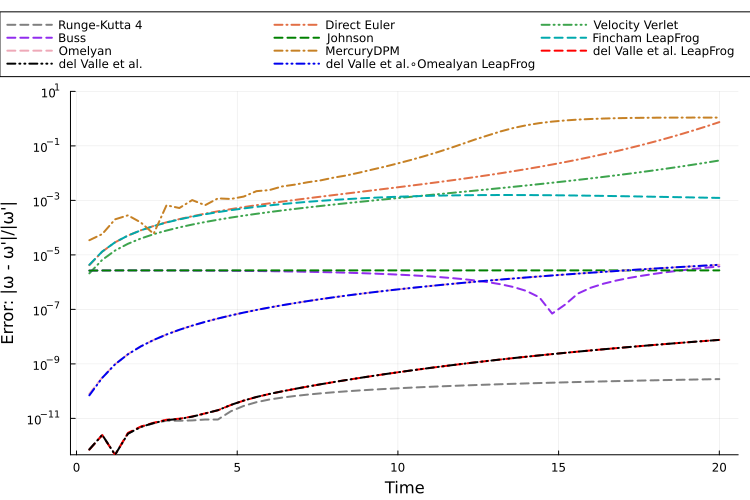

In [35]:
fig = plot(ylabel="Error: |ω - ω'|/|ω'|", xlabel="Time", yscale=:log10, legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
plot!(Rkt4_Time, Rkt4_Error_w, label="Runge-Kutta 4", linewidth=2, color=:gray, linestyle=:dash)
plot!(Euler_Time, Euler_Error_w, label="Direct Euler", linewidth=2, color=:auto, linestyle=:auto)
plot!(Verlet_Time, Verlet_Error_w, label="Velocity Verlet", linewidth=2, color=:auto, linestyle=:auto)
plot!(Buss_Time, Buss_Error_w, label="Buss", linewidth=2, color=:purple2, linestyle=:dash)
plot!(Johnson_Time, Johnson_Error_w, label="Johnson", linewidth=2, color=:green, linestyle=:dash)
plot!(Fincham_Time, Fincham_Error_w, label="Fincham LeapFrog", linewidth=2, color=:auto, linestyle=:auto)
plot!(Omelyan_Time, Omelyan_Error_w, label="Omelyan", linewidth=2, color=:pink2, linestyle=:dash)
plot!(Mercury_Time, Mercury_Error_w, label="MercuryDPM", linewidth=2, color=:auto, linestyle=:dashdot)
plot!(Carlos_L_Time, Carlos_L_Error_w, label="del Valle et al. LeapFrog", linewidth=2, color=:red, linestyle=:dash)
plot!(Carlos_Time, Carlos_Error_w, label="del Valle et al.", linewidth=2, color=:black, linestyle=:dashdotdot)
plot!(Carlos_L_Time2, Carlos_L_Error_w2, label="del Valle et al.∘Omealyan LeapFrog", linewidth=2, color=:blue2, linestyle=:dashdotdot)
#plot!(Rkt_Time, Rkt_Error_w .+ 1e-31, label="DifferentialEquations.jl", linewidth=1.5, color=:gray, linestyle=:solid)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,10)

In [36]:
df = DataFrame(
    Rkt4_Time = Rkt4_Time,
    Rkt4_Error_w = Rkt4_Error_w,
    Rkt4_Error_q = Rkt4_Error_q,
    Euler_Time = Euler_Time,
    Euler_Error_w = Euler_Error_w,
    Euler_Error_q = Euler_Error_q,
    Verlet_Time = Verlet_Time,
    Verlet_Error_w = Verlet_Error_w,
    Verlet_Error_q = Verlet_Error_q,
    Buss_Time = Buss_Time,
    Buss_Error_w = Buss_Error_w,
    Buss_Error_q = Buss_Error_q,
    Johnson_Time = Johnson_Time,
    Johnson_Error_w = Johnson_Error_w,
    Johnson_Error_q = Johnson_Error_q,
    Fincham_Time = Fincham_Time,
    Fincham_Error_w = Fincham_Error_w,
    Fincham_Error_q = Fincham_Error_q,
    Omelyan_Time = Omelyan_Time,
    Omelyan_Error_w = Omelyan_Error_w,
    Omelyan_Error_q = Omelyan_Error_q,
    Mercury_Time = Mercury_Time,
    Mercury_Error_w = Mercury_Error_w,
    Mercury_Error_q = Mercury_Error_q,
    Carlos_L_Time = Carlos_L_Time,
    Carlos_L_Error_w = Carlos_L_Error_w,
    Carlos_L_Error_q = Carlos_L_Error_q,
    Carlos_Time = Carlos_Time,
    Carlos_Error_w = Carlos_Error_w,
    Carlos_Error_q = Carlos_Error_q,
    Carlos_L_Time2 = Carlos_L_Time2,
    Carlos_L_Error_w2 = Carlos_L_Error_w2,
    Carlos_L_Error_q2 = Carlos_L_Error_q2,
    Rkt_Time = Rkt_Time,
    Rkt_Error_w = Rkt_Error_w .+ 1e-31,
    Rkt_Error_q = Rkt_Error_q
)

# Save the DataFrame to a CSV file
CSV.write("Data/qw_error_time.csv", df)

"Data/qw_error_time.csv"

----

# Stability and Energy Conservation

We have 30 multispheres bouncing on a box without damping, friction and gravity. We then can compare the energy conservation capabilities of the different algorithms. The simulations were performed in YADE and MercuryDMP. 

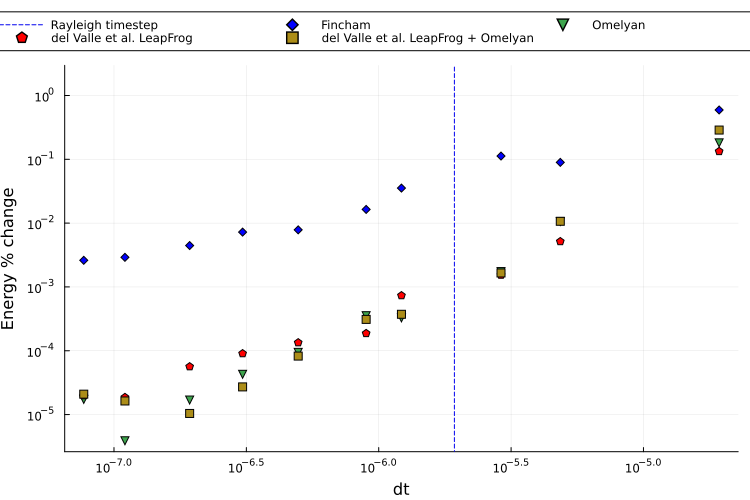

In [37]:
df1 = CSV.read("Data/Fincham_energy.csv", DataFrame, header=true, comment="#")
M1 = Matrix(df1)
df2 = CSV.read("Data/Omelyan98_energy.csv", DataFrame, header=true, comment="#")
M2 = Matrix(df2)
df3 = CSV.read("Data/Carlos_2023_energy.csv", DataFrame, header=true, comment="#")
M3 = Matrix(df3)
df4 = CSV.read("Data/Carlos_Omelyan_2023_energy.csv", DataFrame, header=true, comment="#")
M4 = Matrix(df4)

fig = plot(xscale=:log10, yscale=:log10, ylabel="Energy % change", legend=:outertop, legend_columns=3, size=(750, 500), dpi=500)
vline!([1.9311703796025776e-06], line=:dash, linecolor=:blue2, label="Rayleigh timestep")
scatter!(M1[:, 1], M1[:, 2], xlabel="dt", label="Fincham", color=:blue, markershape=:diamond)
scatter!(M2[:, 1], M2[:, 2], label="Omelyan", markershape=:dtriangle)
scatter!(M3[:, 1], M3[:, 2], label="del Valle et al. LeapFrog", markershape=:pentagon, color=:red)
scatter!(M4[:, 1], M4[:, 2], label="del Valle et al. LeapFrog + Omelyan", markershape=:square, color=:auto)
xticks!(10 .^ range(-8, 0, length=17))
yticks!(10 .^ range(-20, 4, length=25))

In [38]:
df = DataFrame(
    Time_Fincham = M1[:, 1],
    Time_Omelyan = M2[:, 1],
    Time_Carlos = M3[:, 1],
    Time_CarlosO = M4[:, 1],
    Fincham = M1[:, 2],
    Omelyan = M2[:, 2],
    Carlos = M3[:, 2],
    CarlosO = M4[:, 2]
)

# Save the DataFrame to a CSV file
CSV.write("Data/Energy.csv", df)

"Data/Energy.csv"

----

# Performance:

In [39]:
Norm = true
Benchmark_Rkt4 = @benchmark $Rkt4_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Euler = @benchmark $Direct_Euler_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Verlet = @benchmark $Verlet_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Buss = @benchmark $Buss_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
Benchmark_Johnson = @benchmark $Johnson_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
Benchmark_Fincham = @benchmark $Fincham_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Omelyan = @benchmark $Omelyan_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_Mercury = @benchmark $Mercury_step($quat_to_dcm(q0), $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
Benchmark_Carlos = @benchmark $Carlos_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_CarlosL = @benchmark $Carlos_LeapFrog_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
Benchmark_CarlosL2 = @benchmark $Carlos_LeapFrog_Step2($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)

Norm = false
NBenchmark_Rkt4 = @benchmark $Rkt4_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Euler = @benchmark $Direct_Euler_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Verlet = @benchmark $Verlet_step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Buss = @benchmark $Buss_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
NBenchmark_Johnson = @benchmark $Johnson_Step($q0, $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
NBenchmark_Fincham = @benchmark $Fincham_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Omelyan = @benchmark $Omelyan_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_Mercury = @benchmark $Mercury_step($quat_to_dcm(q0), $ω0, $τ, $Inertia0, $dt, normalize=$Norm)
NBenchmark_Carlos = @benchmark $Carlos_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_CarlosL = @benchmark $Carlos_LeapFrog_Step($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm)
NBenchmark_CarlosL2 = @benchmark $Carlos_LeapFrog_Step2($q0, $ω0, $τ, $InertiaP, $dt, normalize=$Norm);

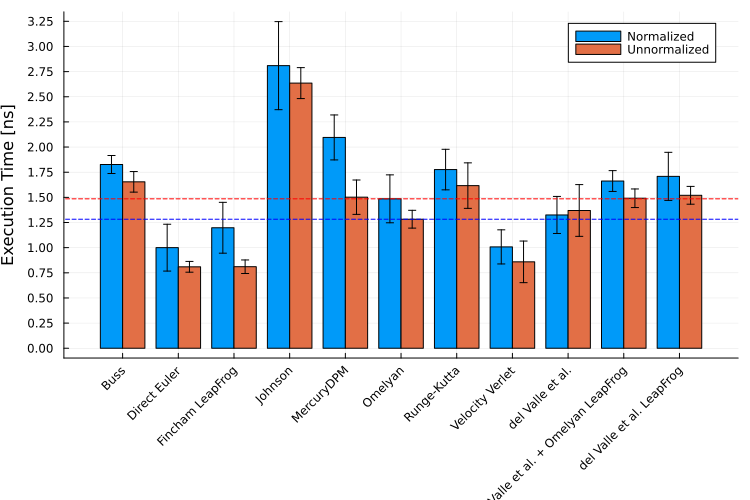

In [40]:
# Get results
results = [
    Benchmark_Euler.times, NBenchmark_Euler.times,
    Benchmark_Omelyan.times, NBenchmark_Omelyan.times,
    Benchmark_Verlet.times, NBenchmark_Verlet.times,
    Benchmark_Buss.times, NBenchmark_Buss.times,
    Benchmark_Fincham.times, NBenchmark_Fincham.times,
    Benchmark_Johnson.times, NBenchmark_Johnson.times,
    Benchmark_Mercury.times, NBenchmark_Mercury.times,
    Benchmark_Rkt4.times, NBenchmark_Rkt4.times,
    Benchmark_Carlos.times, NBenchmark_Carlos.times,
    Benchmark_CarlosL.times, NBenchmark_CarlosL.times,
    Benchmark_CarlosL2.times, NBenchmark_CarlosL2.times
]

# Names of the results
labels = [
    "Direct Euler", "Direct Euler", 
    "Omelyan", "Omelyan",
    "Velocity Verlet", "Velocity Verlet", 
    "Buss", "Buss", 
    "Fincham LeapFrog", "Fincham LeapFrog", 
    "Johnson", "Johnson", 
    "MercuryDPM", "MercuryDPM",
    "Runge-Kutta", "Runge-Kutta",
    "del Valle et al.", "del Valle et al.",
    "del Valle et al. LeapFrog", "del Valle et al. LeapFrog",
    "del Valle et al. + Omelyan LeapFrog", "del Valle et al. + Omelyan LeapFrog"
]

Len = trunc(Int64, length(labels)/2)

# Calculate results statistics
means = mean.(results)
stds = std.(results)

# Normalize time
Reff_time = means[1]
means /= Reff_time
stds /= Reff_time

# Plot results
p = groupedbar(labels, means, yerr=stds, group = repeat(["Normalized", "Unnormalized"], outer=Len),
    xlabel="Method", ylabel="Execution Time [ns]", legend=:topright,
    xrotation=45, size=(750, 500), dpi=500)
hline!([means[3]], line=:dash, linecolor=:red, label="")
yticks!([yticks(p)[1][1]..., round(means[3], digits=4)])
hline!([means[4]], line=:dash, linecolor=:blue, label="")
yticks!([yticks(p)[1][1]..., round(means[4], digits=2)])

yticks!(range(0.0, 3.5, length=15))

----

<font color='red'>
Warning: When looking at this plot, remember that the Runge-Kutta time is greatly idealized. In this toy example, we have a constant torque, but in a real-case scenario, it would need to calculate forces 4 times. Calculating forces implies iterating over all the particles. The other algorithms only do it 1 time. 
</font>

---

In [41]:
df = DataFrame(
    Method = chomp.(labels[1:2:end]),
    TimeN = means[1:2:end],
    ErrorN = stds[1:2:end],
    Time = means[2:2:end],
    Error = stds[2:2:end]
)

# Save the DataFrame to a CSV file
CSV.write("Data/bar_plot_data.csv", df)

"Data/bar_plot_data.csv"

# Speed UP

In [42]:
function Error_dt(DT::Float64, args)::Float64
    interpol_method, target_error = args
    return 10^interpol_method(DT) - target_error
end

function CPU_time_for_error(interpol_method, integration_method, target_error::Float64, Tmax::Float64)
    DT = 10^find_zero(Error_dt, (-7, -1), (interpol_method, target_error))
    
    Benchmark = @benchmark $integration_method($Tmax, $DT, $1)
    return DT, mean(Benchmark.times)
end

function Generate_Speed_Up_Results(target_error::Float64; Tmax::Float64=1.0)
    # Create interpolator for the error
    dt_log = @. log10(dts1)
    dt_range = range(dt_log[1], stop=dt_log[end], length=length(dt_log))
    
    Euler_avg = @. log10(0.5*(Errors1[:,2] + Errors1[:,13]))
    interp_Euler = linear_interpolation(dt_range, Euler_avg, extrapolation_bc=Linear()) 
    
    Verlet_avg = @. log10(0.5*(Errors1[:,3] + Errors1[:,14]))
    interp_Verlet = linear_interpolation(dt_range, Verlet_avg, extrapolation_bc=Linear()) 
    
    Buss_avg = @. log10(0.5*(Errors1[:,4] + Errors1[:,15]))
    interp_Buss = linear_interpolation(dt_range, Buss_avg, extrapolation_bc=Linear()) 
    
    Johnson_avg = @. log10(0.5*(Errors1[:,5] + Errors1[:,16]))
    interp_Johnson = linear_interpolation(dt_range, Johnson_avg, extrapolation_bc=Linear()) 

    Fincham_avg = @. log10(0.5*(Errors1[:,6] + Errors1[:,17]))
    interp_Fincham = linear_interpolation(dt_range, Fincham_avg, extrapolation_bc=Linear())
    
    Omelyan_avg = @. log10(0.5*(Errors1[:,7] + Errors1[:,18]))
    interp_Omelyan = linear_interpolation(dt_range, Omelyan_avg, extrapolation_bc=Linear())
    
    MercuryDPM_avg = @. log10(0.5*(Errors1[:,8] + Errors1[:,19]))
    interp_MercuryDPM = linear_interpolation(dt_range, MercuryDPM_avg, extrapolation_bc=Linear())
    
    CarlosL_avg = @. log10(0.5*(Errors1[:,9] + Errors1[:,20]))
    interp_CarlosL = linear_interpolation(dt_range, CarlosL_avg, extrapolation_bc=Linear())
    
    Carlos_avg = @. log10(0.5*(Errors1[:,10] + Errors1[:,21]))
    interp_Carlos = linear_interpolation(dt_range, Carlos_avg, extrapolation_bc=Linear())
    
    CarlosO_avg = @. log10(0.5*(Errors1[:,11] + Errors1[:,22]))
    interp_CarlosO = linear_interpolation(dt_range, CarlosO_avg, extrapolation_bc=Linear())
    
    Euler_dt, Euler_t = CPU_time_for_error(interp_Euler, Direct_Euler_Simulation, target_error, Tmax)
    Verlet_dt, Verlet_t = CPU_time_for_error(interp_Verlet, Verlet_Simulation, target_error, Tmax)
    Buss_dt, Buss_t = CPU_time_for_error(interp_Buss, Buss_Simulation, target_error, Tmax)
    Johnson_dt, Johnson_t = CPU_time_for_error(interp_Johnson, Johnson_Simulation, target_error, Tmax)
    Fincham_dt, Fincham_t = CPU_time_for_error(interp_Fincham, Fincham_Simulation, target_error, Tmax)
    Omelyan_dt, Omelyan_t = CPU_time_for_error(interp_Omelyan, Omelyan_Simulation, target_error, Tmax)
    Mercury_dt, Mercury_t = CPU_time_for_error(interp_MercuryDPM, Mercury_Simulation, target_error, Tmax)
    Carlos_LeapFrog_dt, Carlos_LeapFrog_t = CPU_time_for_error(interp_CarlosL, Carlos_LeapFrog_Simulation, target_error, Tmax)
    Carlos_dt, Carlos_t = CPU_time_for_error(interp_Carlos, Carlos_Simulation, target_error, Tmax)
    Carlos_Omelyan_dt, Carlos_Omelyan_t = CPU_time_for_error(interp_CarlosO, Carlos_LeapFrog_Simulation2, target_error, Tmax)

    println("\nSped Up for target error = ", target_error, " and simulation time = ", Tmax, " s \n")
    println("Euler time = ", round(Euler_t*1e-9, sigdigits=4), " s, used dt = ", @sprintf("%.3e", Euler_dt))
    println("MercuryDMP Speed Up = x", round(Euler_t/Mercury_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Mercury_dt))
    println("Fincham Speed Up = x", round(Euler_t/Fincham_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Fincham_dt))
    println("Verlet Speed Up = x", round(Euler_t/Verlet_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Verlet_dt))
    println("Johnson Speed Up = x", round(Euler_t/Johnson_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Johnson_dt))
    println("Buss Speed Up = x", round(Euler_t/Buss_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Buss_dt))
    println("Omelyan Speed Up = x", round(Euler_t/Omelyan_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Omelyan_dt))
    println("del Valle et al.+Omelyan Speed Up = x", round(Euler_t/Carlos_Omelyan_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Carlos_Omelyan_dt))
    println("del Valle et al. Speed Up = x", round(Euler_t/Carlos_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Carlos_dt))
    println("del Valle et al. LeapFrog Speed Up = x", round(Euler_t/Carlos_LeapFrog_t, sigdigits=4), " used dt = ", @sprintf("%.3e", Carlos_LeapFrog_dt))

    return nothing
end

Generate_Speed_Up_Results (generic function with 1 method)

In [43]:
Generate_Speed_Up_Results(1e-2)


Sped Up for target error = 0.01 and simulation time = 1.0 s 

Euler time = 5.871e-5 s, used dt = 1.586e-03
MercuryDMP Speed Up = x0.09742 used dt = 2.663e-04
Fincham Speed Up = x2.038 used dt = 4.989e-03
Verlet Speed Up = x1.971 used dt = 4.168e-03
Johnson Speed Up = x0.4283 used dt = 1.791e-03
Buss Speed Up = x9.135 used dt = 6.478e-02
Omelyan Speed Up = x3.704 used dt = 9.388e-03
del Valle et al.+Omelyan Speed Up = x8.176 used dt = 4.157e-02
del Valle et al. Speed Up = x9.53 used dt = 5.794e-02
del Valle et al. LeapFrog Speed Up = x9.499 used dt = 6.356e-02


In [44]:
Generate_Speed_Up_Results(1e-3)


Sped Up for target error = 0.001 and simulation time = 1.0 s 

Euler time = 0.0005941 s, used dt = 1.452e-04
MercuryDMP Speed Up = x0.09585 used dt = 2.607e-05
Fincham Speed Up = x2.271 used dt = 4.576e-04
Verlet Speed Up = x5.614 used dt = 8.389e-04
Johnson Speed Up = x0.4284 used dt = 1.790e-04
Buss Speed Up = x14.1 used dt = 3.542e-03
Omelyan Speed Up = x14.14 used dt = 2.938e-03
del Valle et al.+Omelyan Speed Up = x41.08 used dt = 1.232e-02
del Valle et al. Speed Up = x54.38 used dt = 1.748e-02
del Valle et al. LeapFrog Speed Up = x62.77 used dt = 2.475e-02


In [45]:
Generate_Speed_Up_Results(1e-4)


Sped Up for target error = 0.0001 and simulation time = 1.0 s 

Euler time = 0.005955 s, used dt = 1.442e-05
MercuryDMP Speed Up = x0.09677 used dt = 2.601e-06
Fincham Speed Up = x2.267 used dt = 4.522e-05
Verlet Speed Up = x5.829 used dt = 8.818e-05
Johnson Speed Up = x0.4489 used dt = 1.790e-05
Buss Speed Up = x13.92 used dt = 3.246e-04
Omelyan Speed Up = x48.03 used dt = 9.290e-04
del Valle et al.+Omelyan Speed Up = x159.7 used dt = 3.923e-03
del Valle et al. Speed Up = x230.3 used dt = 5.420e-03
del Valle et al. LeapFrog Speed Up = x305.3 used dt = 9.440e-03


In [46]:
Generate_Speed_Up_Results(1e-5)


Sped Up for target error = 1.0e-5 and simulation time = 1.0 s 

Euler time = 0.06054 s, used dt = 1.441e-06
MercuryDMP Speed Up = x0.09806 used dt = 2.600e-07
Fincham Speed Up = x2.321 used dt = 4.516e-06
Verlet Speed Up = x6.145 used dt = 8.767e-06
Johnson Speed Up = x0.4638 used dt = 1.790e-06
Buss Speed Up = x14.41 used dt = 3.226e-05
Omelyan Speed Up = x159.4 used dt = 2.935e-04
del Valle et al.+Omelyan Speed Up = x564.7 used dt = 1.250e-03
del Valle et al. Speed Up = x862.1 used dt = 1.704e-03
del Valle et al. LeapFrog Speed Up = x1443.0 used dt = 3.413e-03


---

# Quaternion Normalization Effect

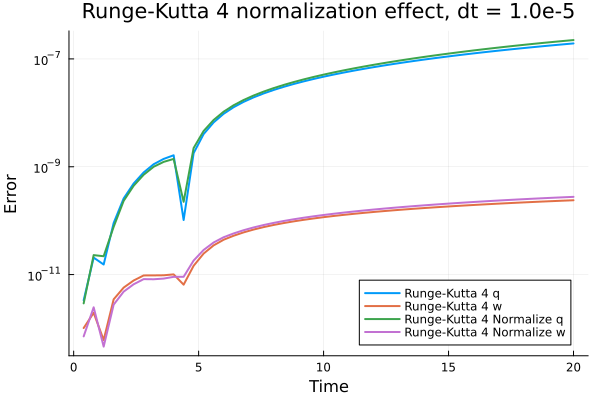

In [47]:
fig = plot(title="Runge-Kutta 4 normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NEuler_Time, NRkt4_Error_q, label="Runge-Kutta 4 q", linewidth=2)
plot!(NEuler_Time, NRkt4_Error_w, label="Runge-Kutta 4 w", linewidth=2)
plot!(Euler_Time, Rkt4_Error_q, label="Runge-Kutta 4 Normalize q", linewidth=2)
plot!(Euler_Time, Rkt4_Error_w, label="Runge-Kutta 4 Normalize w", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

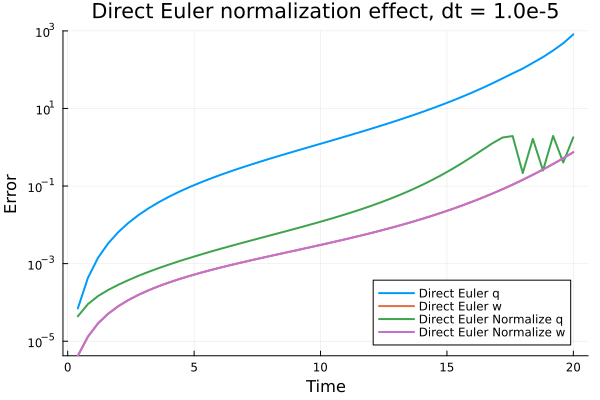

In [48]:
fig = plot(title="Direct Euler normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NEuler_Time, NEuler_Error_q, label="Direct Euler q", linewidth=2)
plot!(NEuler_Time, NEuler_Error_w, label="Direct Euler w", linewidth=2)
plot!(Euler_Time, Euler_Error_q, label="Direct Euler Normalize q", linewidth=2)
plot!(Euler_Time, Euler_Error_w, label="Direct Euler Normalize w", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,1000)

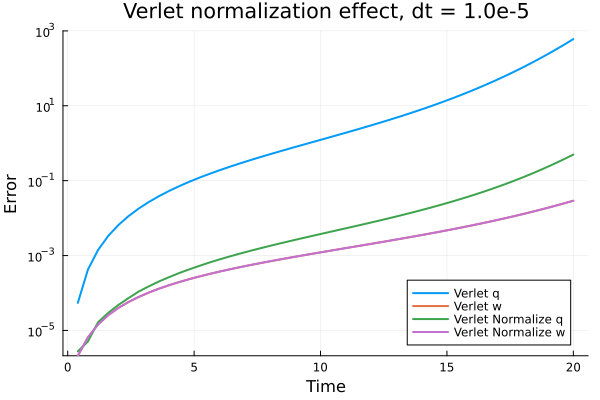

In [49]:
fig = plot(title="Verlet normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NVerlet_Time, NVerlet_Error_q, label="Verlet q", linewidth=2)
plot!(NVerlet_Time, NVerlet_Error_w, label="Verlet w", linewidth=2)
plot!(Verlet_Time, Verlet_Error_q, label="Verlet Normalize q", linewidth=2)
plot!(Verlet_Time, Verlet_Error_w, label="Verlet Normalize w", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,1000)

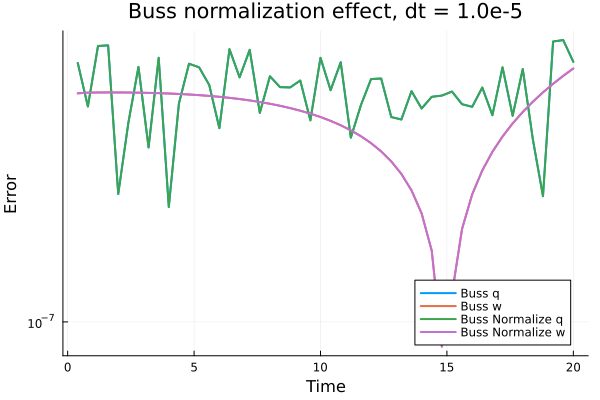

In [50]:
fig = plot(title="Buss normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NBuss_Time, NBuss_Error_q, label="Buss q", linewidth=2)
plot!(NBuss_Time, NBuss_Error_w, label="Buss w", linewidth=2)
plot!(Buss_Time, Buss_Error_q, label="Buss Normalize q", linewidth=2)
plot!(Buss_Time, Buss_Error_w, label="Buss Normalize w", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

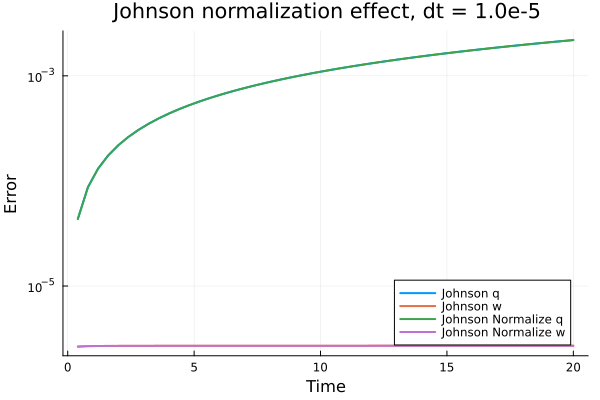

In [51]:
fig = plot(title="Johnson normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NJohnson_Time, NJohnson_Error_q, label="Johnson q", linewidth=2)
plot!(NJohnson_Time, NJohnson_Error_w, label="Johnson w", linewidth=2)
plot!(Johnson_Time, Johnson_Error_q, label="Johnson Normalize q", linewidth=2)
plot!(Johnson_Time, Johnson_Error_w, label="Johnson Normalize w", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

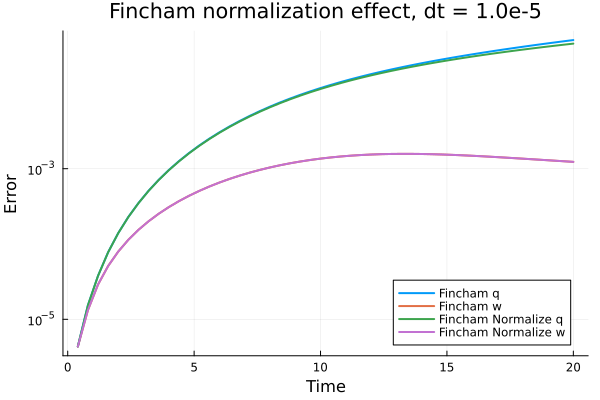

In [52]:
fig = plot(title="Fincham normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NFincham_Time, NFincham_Error_q, label="Fincham q", linewidth=2)
plot!(NFincham_Time, NFincham_Error_w, label="Fincham w", linewidth=2)
plot!(Fincham_Time, Fincham_Error_q, label="Fincham Normalize q", linewidth=2)
plot!(Fincham_Time, Fincham_Error_w, label="Fincham Normalize w", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

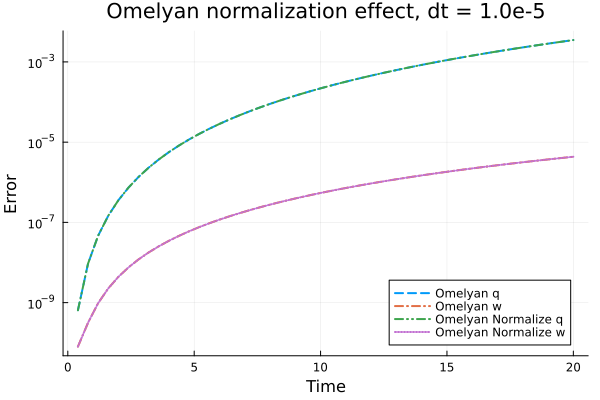

In [53]:
fig = plot(title="Omelyan normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NOmelyan_Time, NOmelyan_Error_q, label="Omelyan q", linewidth=2, linestyle=:auto)
plot!(NOmelyan_Time, NOmelyan_Error_w, label="Omelyan w", linewidth=2, linestyle=:auto)
plot!(Omelyan_Time, Omelyan_Error_q, label="Omelyan Normalize q", linewidth=2, linestyle=:auto)
plot!(Omelyan_Time, Omelyan_Error_w, label="Omelyan Normalize w", linewidth=2, linestyle=:auto)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

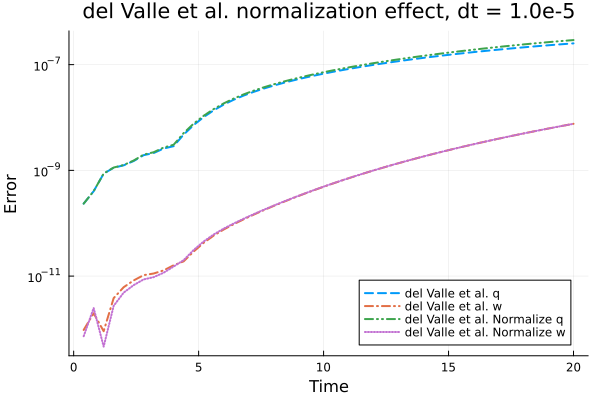

In [54]:
fig = plot(title="del Valle et al. normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NCarlos_Time, NCarlos_Error_q, label="del Valle et al. q", linewidth=2, linestyle=:auto)
plot!(NOmelyan_Time, NCarlos_Error_w, label="del Valle et al. w", linewidth=2, linestyle=:auto)
plot!(Carlos_Time, Carlos_Error_q, label="del Valle et al. Normalize q", linewidth=2, linestyle=:auto)
plot!(Carlos_Time, Carlos_Error_w, label="del Valle et al. Normalize w", linewidth=2, linestyle=:auto)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

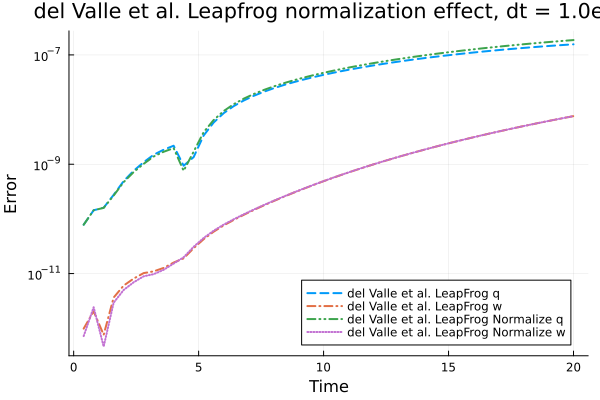

In [55]:
fig = plot(title="del Valle et al. Leapfrog normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NCarlos_L_Time, NCarlos_L_Error_q, label="del Valle et al. LeapFrog q", linewidth=2, linestyle=:auto)
plot!(NCarlos_L_Time, NCarlos_L_Error_w, label="del Valle et al. LeapFrog w", linewidth=2, linestyle=:auto)
plot!(Carlos_L_Time, Carlos_L_Error_q, label="del Valle et al. LeapFrog Normalize q", linewidth=2, linestyle=:auto)
plot!(Carlos_L_Time, Carlos_L_Error_w, label="del Valle et al. LeapFrog Normalize w", linewidth=2, linestyle=:auto)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

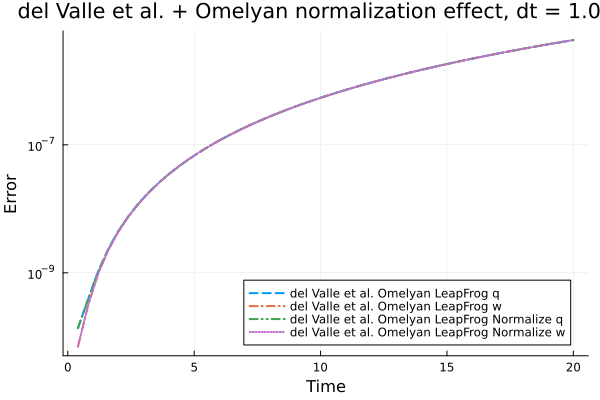

In [56]:
fig = plot(title="del Valle et al. + Omelyan normalization effect, dt = "*string(dt), ylabel="Error", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(NCarlos_L_Time2, NCarlos_L_Error_q2, label="del Valle et al. Omelyan LeapFrog q", linewidth=2, linestyle=:auto)
plot!(NCarlos_L_Time2, NCarlos_L_Error_w2, label="del Valle et al. Omelyan LeapFrog w", linewidth=2, linestyle=:auto)
plot!(Carlos_L_Time2, Carlos_L_Error_q2, label="del Valle et al. Omelyan LeapFrog Normalize q", linewidth=2, linestyle=:auto)
plot!(Carlos_L_Time2, Carlos_L_Error_w2, label="del Valle et al. Omelyan LeapFrog Normalize w", linewidth=2, linestyle=:auto)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))

---

# Omelyan Nonlinear System Convergence:

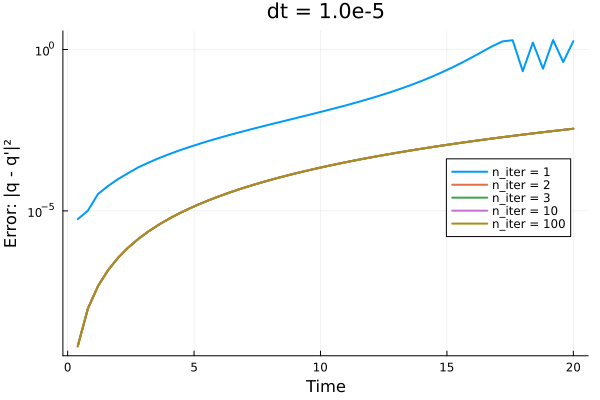

In [57]:
Norm = true
Omelyan_Time1, Omelyan_Error_q1, Omelyan_Error_w1, Omelyan_Prediction1 = Omelyan_Simulation(tmax, dt, samples, niter=1, normalize=Norm)
Omelyan_Time2, Omelyan_Error_q2, Omelyan_Error_w2, Omelyan_Prediction2 = Omelyan_Simulation(tmax, dt, samples, niter=2, normalize=Norm)
Omelyan_Time3, Omelyan_Error_q3, Omelyan_Error_w3, Omelyan_Prediction3 = Omelyan_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
Omelyan_Time10, Omelyan_Error_q10, Omelyan_Error_w10, Omelyan_Prediction10 = Omelyan_Simulation(tmax, dt, samples, niter=10, normalize=Norm)
Omelyan_Time100, Omelyan_Error_q100, Omelyan_Error_w100, Omelyan_Prediction100 = Omelyan_Simulation(tmax, dt, samples, niter=100, normalize=Norm)

Norm = false
NOmelyan_Time1, NOmelyan_Error_q1, NOmelyan_Error_w1, NOmelyan_Prediction1 = Omelyan_Simulation(tmax, dt, samples, niter=1, normalize=Norm)
NOmelyan_Time2, NOmelyan_Error_q2, NOmelyan_Error_w2, NOmelyan_Prediction2 = Omelyan_Simulation(tmax, dt, samples, niter=2, normalize=Norm)
NOmelyan_Time3, NOmelyan_Error_q3, NOmelyan_Error_w3, NOmelyan_Prediction3 = Omelyan_Simulation(tmax, dt, samples, niter=3, normalize=Norm)
NOmelyan_Time10, NOmelyan_Error_q10, NOmelyan_Error_w10, NOmelyan_Prediction10 = Omelyan_Simulation(tmax, dt, samples, niter=10, normalize=Norm)
NOmelyan_Time100, NOmelyan_Error_q100, NOmelyan_Error_w100, NOmelyan_Prediction100 = Omelyan_Simulation(tmax, dt, samples, niter=100, normalize=Norm)

fig = plot(title="dt = "*string(dt), ylabel="Error: |q - q'|²", xlabel="Time", yscale=:log10, legend=:right)
plot!(Omelyan_Time1, Omelyan_Error_q1, label="n_iter = 1", linewidth=2)
plot!(Omelyan_Time2, Omelyan_Error_q2, label="n_iter = 2", linewidth=2)
plot!(Omelyan_Time3, Omelyan_Error_q3, label="n_iter = 3", linewidth=2)
plot!(Omelyan_Time10, Omelyan_Error_q10, label="n_iter = 10", linewidth=2)
plot!(Omelyan_Time100, Omelyan_Error_q100, label="n_iter = 100", linewidth=2)

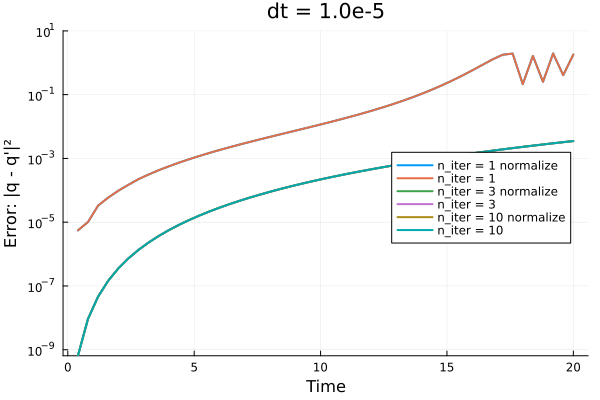

In [58]:
fig = plot(title="dt = "*string(dt), ylabel="Error: |q - q'|²", xlabel="Time", yscale=:log10, legend=:right)
plot!(Omelyan_Time1, Omelyan_Error_q1, label="n_iter = 1 normalize", linewidth=2)
plot!(NOmelyan_Time1, NOmelyan_Error_q1, label="n_iter = 1", linewidth=2)
plot!(Omelyan_Time3, Omelyan_Error_q3, label="n_iter = 3 normalize", linewidth=2)
plot!(NOmelyan_Time3, NOmelyan_Error_q3, label="n_iter = 3", linewidth=2)
plot!(Omelyan_Time10, Omelyan_Error_q10, label="n_iter = 10 normalize", linewidth=2)
plot!(NOmelyan_Time10, NOmelyan_Error_q10, label="n_iter = 10", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,10)

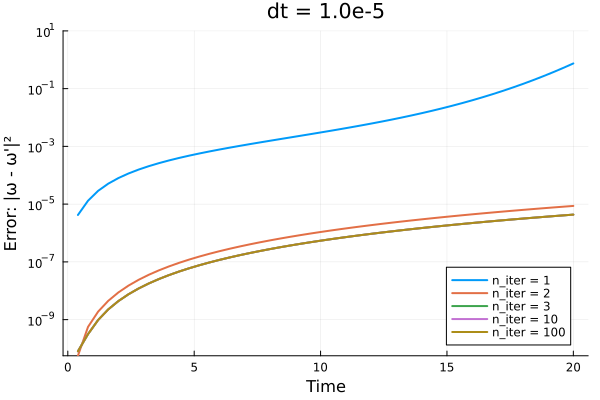

In [59]:
fig = plot(title="dt = "*string(dt), ylabel="Error: |ω - ω'|²", xlabel="Time", yscale=:log10, legend=:bottomright)
plot!(Omelyan_Time1, Omelyan_Error_w1, label="n_iter = 1", linewidth=2)
plot!(Omelyan_Time2, Omelyan_Error_w2, label="n_iter = 2", linewidth=2)
plot!(Omelyan_Time3, Omelyan_Error_w3, label="n_iter = 3", linewidth=2)
plot!(Omelyan_Time10, Omelyan_Error_w10, label="n_iter = 10", linewidth=2)
plot!(Omelyan_Time100, Omelyan_Error_w100, label="n_iter = 100", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,10)

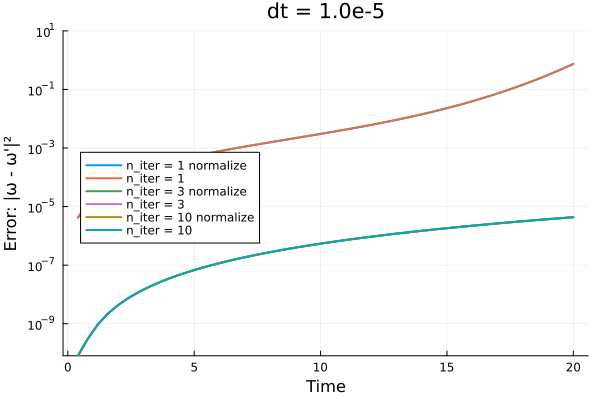

In [60]:
fig = plot(title="dt = "*string(dt), ylabel="Error: |ω - ω'|²", xlabel="Time", yscale=:log10, legend=:left)
plot!(Omelyan_Time1, Omelyan_Error_w1, label="n_iter = 1 normalize", linewidth=2)
plot!(NOmelyan_Time1, NOmelyan_Error_w1, label="n_iter = 1", linewidth=2)
plot!(Omelyan_Time3, Omelyan_Error_w3, label="n_iter = 3 normalize", linewidth=2)
plot!(NOmelyan_Time3, NOmelyan_Error_w3, label="n_iter = 3", linewidth=2)
plot!(Omelyan_Time10, Omelyan_Error_w10, label="n_iter = 10 normalize", linewidth=2)
plot!(NOmelyan_Time10, NOmelyan_Error_w10, label="n_iter = 10", linewidth=2)
yticks!(10 .^ range(log10(10e-26), log10(1000), length=15))
ylims!(-Inf,10)

----

# Cylinder rendering

In [61]:
using GLMakie

In [62]:
function Create_Cylinders(i)
    # Get orientation
    Euler_q = Quaternion(Euler_Prediction[i,1:4])
    Carlos_LeapFrog_q = Quaternion(Carlos_L_Prediction[i,1:4])
    
    time = Euler_Time[i]
    Rkt_Q = Quaternion(Rkt_sol_q(time)[1:4])
    
    println("time = ", time)
    
    # Find orientation axis
    A = SVector(1.0, 0.0, 0.0)
    Euler_Axis = Hight*0.5*Lab_to_body(A, Euler_q)
    Carlos_LeapFrog_Axis = Hight*0.5*Lab_to_body(A, Carlos_LeapFrog_q)
    Rkt_Axis = Hight*0.5*Lab_to_body(A, Rkt_Q)

    # Create cylinders
    cyl1 = Cylinder(Rad, Segment((-Rkt_Axis[1], -Rkt_Axis[2], -Rkt_Axis[3]), (Rkt_Axis[1], Rkt_Axis[2], Rkt_Axis[3])))
    cyl2 = Cylinder(Rad, Segment((-Euler_Axis[1], -Euler_Axis[2], -Euler_Axis[3]), (Euler_Axis[1], Euler_Axis[2], Euler_Axis[3])))
    cyl4 = Cylinder(Rad, Segment((-Carlos_LeapFrog_Axis[1], -Carlos_LeapFrog_Axis[2], -Carlos_LeapFrog_Axis[3]), (Carlos_LeapFrog_Axis[1], Carlos_LeapFrog_Axis[2], Carlos_LeapFrog_Axis[3])))

    # Create visualization objects for each cylinder
    fig = viz(cyl1, color=:orange, alpha=1, label="Rkt", size=(750, 500), dpi=500)
    #viz!(cyl2, color=:gray, alpha=0.8, label="Euler")
    #viz!(cyl4, color=:blue, alpha=0.8, label="Carlos LeapFrog")
    
    return fig
end

Create_Cylinders (generic function with 1 method)

In [63]:
fig = Create_Cylinders(50)
fig.axis.show_axis = false
GL.cam3d!(fig.figure.scene);
GL.display(fig)

time = 19.999499999412034


LoadError: MethodError: no method matching Cylinder(::Float64, ::Segment{3, Float64, Vector{Meshes.Point3}})
[0mClosest candidates are:
[0m  Cylinder(::T) where T at ~/.julia/packages/Meshes/uPQGa/src/primitives/cylinder.jl:45

In [64]:
GL.save("Figures/Render_pres.png", fig)

LoadError: UndefVarError: GL not defined

In [65]:
#using Makie
# Define the function to create an animated cylinder
function animate_cylinder(radius_function, frame_count)
    # Create an Observable for the radius
    radius = GL.Observables.Observable(radius_function(0))

    # Create the scene
    scene = GL.Scene(resolution = (800, 600))

    # Create the initial cylinder
    cylinder = Cylinder(radius[], Segment((0.0, 0.0, 0.0),(1.0, 0.0, 0.0)))

    # Add the cylinder to the scene
    fig = viz(cylinder, color=:orange, alpha=1, label="Rkt", size=(750, 500), dpi=500)

    # Define the update function to change the radius over time
    function update(frame)
        # Update the radius using the provided function
        radius[] = radius_function(frame)

        # Update the cylinder
        update_cylinder!(cylinder, radius[], [1, 0, 0])
    end

    # Create an animated scene
    #animate!(scene, fps = 30, update)
end

# Define a radius function that changes over time
function radius_function(frame)
    return 0.5 + sin(frame * 0.1) * 0.4  # Example radius function
end

# Call the animate_cylinder function
animate_cylinder(radius_function, 300)  # Change the frame count as needed


LoadError: UndefVarError: GL not defined

In [66]:
radius = GL.Observables.Observable(radius_function(0))
cylinder = Cylinder(radius[], Segment((0.0, 0.0, 0.0),(1.0, 0.0, 0.0)))
fig = viz(cylinder, color=:orange, alpha=1, label="Rkt", size=(750, 500), dpi=500)
GL.display(fig)

LoadError: UndefVarError: GL not defined

In [67]:
for i in 1:100
    radius = 0.5 + sin(i * 0.1) * 0.4 
    viz!(cylinder, color=:orange, alpha=1, label="Rkt", size=(750, 500), dpi=500)
end

LoadError: UndefVarError: cylinder not defined

In [68]:
time = GL.Observable(0.0)

xs = range(0, 7, length=40)

ys_1 = GL.@lift(sin.(xs .- $time))
ys_2 = GL.@lift(cos.(xs .- $time) .+ 3)

fig = GL.lines(xs, ys_1, color = :blue, linewidth = 4,
    axis = (title = GL.@lift("t = $(round($time, digits = 1))"),))
scatter!(xs, ys_2, color = :red, markersize = 15)

framerate = 30
timestamps = range(0, 2, step=1/framerate)

record(fig, "time_animation.gif", timestamps;
        framerate = framerate) do t
    time[] = t
end

LoadError: UndefVarError: GL not defined